# input

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
import numpy as np
import pandas as pd
import pypsa
import xarray as xr
import tikzplotlib
import seaborn as sns

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # or 'xelatex' or 'lualatex'
    "font.family": "serif",
    "text.usetex": True,  # Use LaTeX to write all text
    "pgf.rcfonts": False,  # Do not set up fonts from rc parameters
})

tech_colors = {
    "local": "#b474b4",
    "PPA": "#b474b4",
    "grid": "#9ccc65",
    "grid imports": "#9ccc65",
    "revenue": "g",
    "wind": "#74c6f2",
    "offshore wind": "#6895dd",
    "onshore wind": "#74c6f2",
    "solar": "#ffef60",
    "solar rooftop": "#000000",
    "advanced nuclear": "#df3439",
    "advanced geothermal": "#99582a",
    "advanced dispatchable": "#99582a",
    "NG-Allam": "#540b0e",
    "hydroelectricity": "#298c81",
    "nuclear": "#ff8c00",
    "battery": "#666666",
    "battery discharger": "#444444",
    "battery inverter": "#444444",
    "battery storage": "#666666",
    "hydrogen storage": "#cc00be",
    "hydrogen fuel cell": "#990090",
    "hydrogen electrolysis": "#550055",
    "pumped hydro storage": "#51dbcc",
    "OCGT": "#d35050",
    "CCGT": "#b20101",
    "Gas OC": "#d35050",
    "hard coal": "#545454",
    "lignite": "#826837",
    "oil": "#808080",
    "solid biomass": "#baa741",
    "lines": "#6c9459",
    "transmission lines": "#6c9459",
    "electricity distribution grid": "#97ad8c",
    "load shedding": "red",
}

rename_system_simple = {
    'system_inv_offwind-ac': 'offshore wind',
    'system_inv_offwind-dc': 'offshore wind',
    'system_inv_onwind': 'onshore wind',
    'system_inv_solar': 'solar',
    'system_inv_OCGT': 'Gas OC',
    'system_inv_battery_discharger': 'battery inverter',
    'system_inv_H2_Fuel_Cell': 'hydrogen fuel cell',
    'system_inv_H2_Electrolysis': 'hydrogen electrolysis'
}

rename_ci_cost = pd.Series({
        "onwind" : "onshore wind",
        "solar" : "solar",
        "grid" : "grid imports",
        'revenue': "revenue",
        "battery_storage" : "battery storage",
        "battery_inverter" : "battery inverter",
        'battery_discharger':"battery discharger",
        "hydrogen_storage" : "hydrogen storage",
        "hydrogen_electrolysis": "hydrogen electrolysis",
        "hydrogen_fuel_cell": "hydrogen fuel cell",
        #"adv_nuclear" : "advanced dispatchable",
        #'adv_geothermal': "advanced geothermal",
        'adv_geothermal': "advanced dispatchable",
        'allam_ccs': "NG-Allam",
        'load_shedding': "load shedding",})

rename_ci_capacity= pd.Series({
        "onwind" : "onshore wind",
        "solar" : "solar",
        'battery_discharger':"battery inverter",
        "H2_Fuel_Cell": "hydrogen fuel cell",
        "H2_Electrolysis": "hydrogen electrolysis",
        'adv_geothermal': "advanced dispatchable",
        'allam_ccs': "NG-Allam",
        'load_shedding': "load shedding"})

preferred_order = [
    "advanced dispatchable",
    "NG-Allam",
    'Gas OC',
    "offshore wind",
    "onshore wind",
    "solar",
    "battery inverter",
    "battery storage",
    "hydrogen storage",
    "hydrogen electrolysis",
    "hydrogen fuel cell"
]

# Model Adjustments and Validation

## compare capacity factors in network files
Solar capacity factors SARAH ERA5 comparison over time


In [24]:
def compare_solar_capacity_factors(net1, net2, country_bus, month):
    # Filter solar generators in each network
    solar_generators_net1 = net1.generators[(net1.generators.carrier == 'solar') & (net1.generators.bus == country_bus)]
    solar_generators_net2 = net2.generators[(net2.generators.carrier == 'solar') & (net2.generators.bus == country_bus)]

    # Extract solar generators' p_max_pu for each network
    solar_p_max_pu_net1 = net1.generators_t.p_max_pu.loc[:, solar_generators_net1.index]
    solar_p_max_pu_net2 = net2.generators_t.p_max_pu.loc[:, solar_generators_net2.index]
    
    # Perform statistical analysis
    stats_net1 = solar_p_max_pu_net1.describe()
    stats_net2 = solar_p_max_pu_net2.describe()

    # Calculate the difference
    difference = solar_p_max_pu_net1.mean(axis=1) - solar_p_max_pu_net2.mean(axis=1)
    stats_difference = difference.describe()

    # Compare statistics
    comparison = pd.concat([stats_net1, stats_net2], axis=1, keys=['Network 1', 'Network 2'])

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(5.45, 6), sharex=True)
    # Plot for Network 1 and Network 2
    axes[0].plot(solar_p_max_pu_net1.mean(axis=1), label='ERA5', drawstyle='steps-post')
    axes[0].plot(solar_p_max_pu_net2.mean(axis=1), label='SARAH', drawstyle='steps-post')
    axes[0].set_title(f'Solar Capacity Factors 2013 in Bus "{country_bus}"')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Capacity Factor')
    axes[0].legend()
    # Annotate with statistics
    textstr = '\n'.join((
        f'ERA5 Mean: {stats_net1.loc["mean"].mean():.2f}',
        f'SARAH Mean: {stats_net2.loc["mean"].mean():.2f}'))
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, verticalalignment='top')

    # Plot for the difference
    axes[1].plot(difference, label='Difference (ERA5 - SARAH)', color='red', drawstyle='steps-post')
    axes[1].set_title('Difference in Solar Capacity Factors')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Difference in Capacity Factor')
    axes[1].legend()
    # Annotate with statistics
    diff_textstr = '\n'.join((
        f'Mean Difference: {stats_difference.loc["mean"]:.2f}',
        #f'Std Dev: {stats_difference.loc["std"]:.2f}'
        ))
    axes[1].text(0.05, 0.95, diff_textstr, transform=axes[1].transAxes, verticalalignment='top')
    #adjust tick labels and rotation and date format
    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)
    axes[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d.%m.'))
    axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d.%m.'))

    
    #adjust x limits to show month
    if not isinstance(month, list):
        month = [month]    
    axes[0].set_xlim(solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[0], solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[-1])
    axes[1].set_xlim(solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[0], solar_p_max_pu_net1[solar_p_max_pu_net1.index.month.isin(month)].index[-1])
    #add grid
    axes[0].grid()
    axes[1].grid()

    plt.tight_layout()
    #save figure
    plt.savefig(f"../plots/solar_capacity_factors_comparison_month{'{}-{}'.format(month[0], month[-1]) if len(month) > 1 else str(month[0])}.pgf")
    #tikzplotlib.save(f"../plots/solar_capacity_factors_comparison_month{'{}-{}'.format(month[0], month[-1]) if len(month) > 1 else str(month[0])}.tex")
    plt.show()


    return comparison, stats_difference

export: run for month 6 an 12.
pgfplot needs manipulation: 
>\begin{groupplot}[group style={group size=1 by 2, vertical sep=2cm}, width=18cm, height=8cm]

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

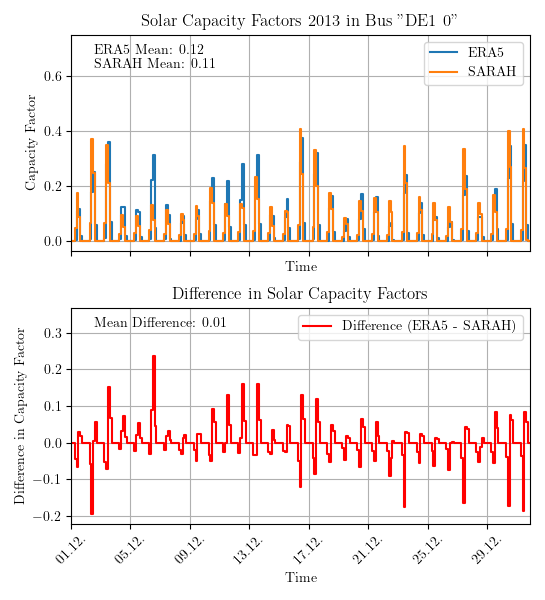

(                 Network 1                                      \
 Generator DE1 0 solar-2025 DE1 0  solar-2000 DE1 0  solar-2005   
 count          2920.000000       2920.000000       2920.000000   
 mean              0.115585          0.115585          0.115585   
 std               0.166499          0.166499          0.166499   
 min               0.000000          0.000000          0.000000   
 25%               0.000000          0.000000          0.000000   
 50%               0.010372          0.010372          0.010372   
 75%               0.201166          0.201166          0.201166   
 max               0.679991          0.679991          0.679991   
 
                                                                  \
 Generator DE1 0  solar-2010 DE1 0  solar-2015 DE1 0  solar-2020   
 count           2920.000000       2920.000000       2920.000000   
 mean               0.115585          0.115585          0.115585   
 std                0.166499          0.166499          

In [62]:
#n = xr.open_dataset("../input/profile_solar_2013.nc")
n1 = pypsa.Network("../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc")
n2 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')

compare_solar_capacity_factors(n1, n2, 'DE1 0', [12]) #specify month in brackets

## Comparison of installed capacities with and without NECPs

INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/tmp/ipykernel_807519/2648901919.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_807519/2648901919.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_807519/2648901919.py:88: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



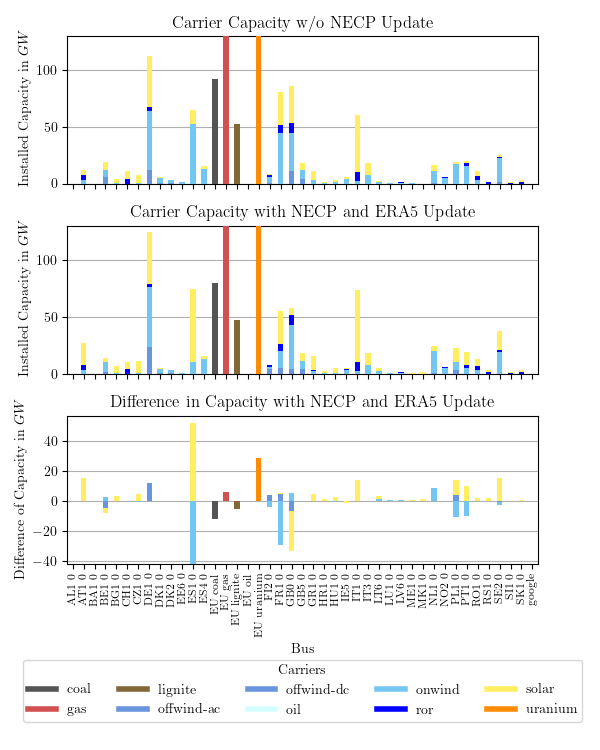

       carrier   
p_nom  coal          -12.1
       gas             6.3
       lignite        -5.5
       offwind         0.0
       offwind-ac     -2.9
       offwind-dc     15.1
       oil             0.0
       onwind        -82.4
       ror             0.0
       solar         109.1
       uranium        28.6
dtype: float64

In [4]:
def plot_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each bus in given networks,
    and adds a subplot showing the difference in p_nom values between networks.
    Each dataframe is plotted in a subplot with consistent color coding for carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(6, 2.5 * (num_dfs + 1)), sharex=True)

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]

    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []

    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.generators['carrier'].unique())
    colors = mcolors.XKCD_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}
    carrier_colors.update({
        "offwind": "#6895dd",
        "offwind-ac": "#6895dd",
        "offwind-dc": "#6895dd",
        "onwind": "#74c6f2",
        "solar": "#ffef60",
        "uranium": "#ff8c00",
        "gas": "#d35050",
        "coal": "#545454",
        "lignite": "#826837",
        "ror": "blue"
        })

    for i, network in enumerate(networks):
        # Check if network has been solved and a valid p_nom_opt column exists
        if 'p_nom_opt' in network.generators.columns and not network.generators['p_nom_opt'].isna().any():
            capacity_column = 'p_nom_opt'
        else:
            capacity_column = 'p_nom'
            
        # Filtering only the relevant columns: 'bus', 'carrier', and 'p_nom'
        filtered_df = network.generators[['bus', 'carrier', capacity_column]]
        filtered_df.rename(columns={capacity_column: 'p_nom'}, inplace=True) if capacity_column != 'p_nom' else None

        # Group and sum the p_nom values per bus and carrier
        grouped_df = filtered_df.groupby(['bus', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_df)

        # Plotting on the respective subplot with consistent colors
        (grouped_df/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_df.columns.get_level_values(1)],zorder=3)
        axes[0].set_title(f'Carrier Capacity w/o NECP Update')
        axes[1].set_title(f'Carrier Capacity with NECP and ERA5 Update')
        axes[i].set_xlabel('Bus')
        axes[i].set_yticks([0,50,100,150,200,250,300])
        axes[i].set_ylim(0, 130)
        axes[i].set_ylabel(f'Installed Capacity in $GW$')
        axes[i].grid(True, axis='y', zorder=0)
        
        #custom legend
        carrier_labels = [carrier for carrier in grouped_df.columns.get_level_values(1)]
        #drop 'offwind'
        carrier_labels = [carrier for carrier in carrier_labels if carrier != 'offwind']
        custom_legend = [plt.Line2D([0], [0], color=carrier_colors[carrier], lw=4) for carrier in carrier_labels]
        #axes[i].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].legend().remove()

    # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)],zorder=3)
        axes[-1].set_title('Difference in Capacity with NECP and ERA5 Update')
        axes[-1].set_xlabel('Bus')
        axes[-1].tick_params(axis='x', labelsize=8)
        axes[-1].set_ylabel('Difference of Capacity in $GW$')
        axes[-1].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(0.5, -0.6), loc='upper center', ncols=5)

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        #axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"../plots/carrier_capacity_comparison.pgf")
    plt.show()
    return (total_difference_per_carrier/1000).round(1)

n1 = pypsa.Network("../results/04_25-EU_DE_scenario_1_SARAH_noNECPs/networks/10/2025/DE/p1/2013/ref.nc")
n2 = pypsa.Network('../results/04_21-EU_DE_scenario_1/networks/10/2025/DE/p1/2013/ref.nc')
plot_capacity_summaries(n1, n2)


# Scen 1: Plot weather year comparison

## scen 1: old weather year comparision

/tmp/ipykernel_716047/74380540.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



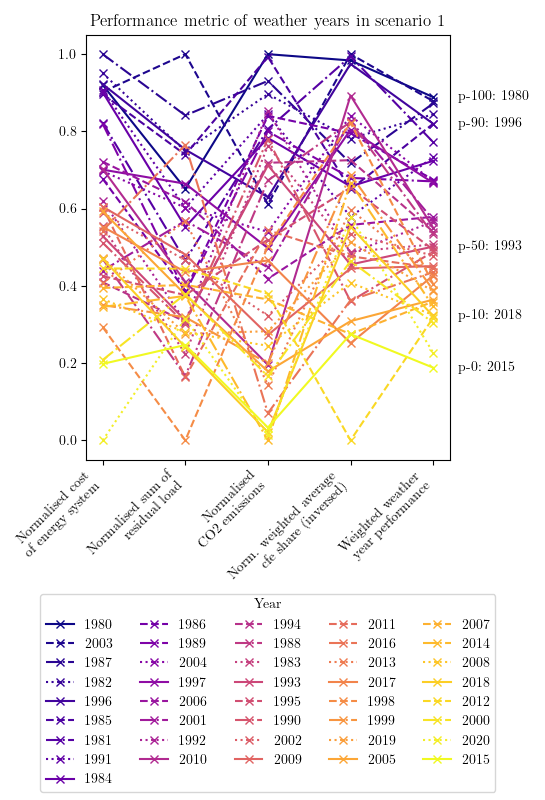

In [96]:
def plot_wy(df):
    df.reset_index(inplace=True)
    # Split the dataframe based on the unique policies in column 0
    groups = df.groupby(df.columns[0])

    # Prepare the colormap
    total_years = len(df['year'].unique())
    colormap = cm.get_cmap('plasma', total_years)  # Get the 'plasma' colormap
    normalize = mcolors.Normalize(vmin=0, vmax=total_years-1)

    line_styles = ['-', '--', '-.', ':']
    markers = ['x'] #, 's', '^', 'D', '*', 'p', 'h']

    fig, ax = plt.subplots(groups.ngroups,1,figsize=(5.45, 8*groups.ngroups), sharex=True)
    if not isinstance(ax, np.ndarray):
        ax = [ax]

    # Iterate over each group
    for j, (group_name, group_df) in enumerate(groups):
        rename_dict = {
            "emissions" : "Total CO2 emissions",
            "objective" : "Total cost of energy system",
            "rldc_sum" : "Total residual load",
            "system_grid_cfe_wavg" : "Average grid carbon\nbound energy share",
            "emissions_weight" : "Normalised\nCO2 emissions",
            "objective_weight" : "Normalised cost\nof energy system",
            "rldc_sum_weight" : "Normalised sum of\nresidual load",
            "system_grid_cfe_wavg_weight" : "Norm. weighted average\ncfe share (inversed)",
            "weighted_score_weight" : "Weighted weather\nyear performance"
        }
        group_df.rename(columns=rename_dict, inplace=True)
        # pick columns to plot
        columns_to_plot = [  "Normalised cost\nof energy system","Normalised sum of\nresidual load","Normalised\nCO2 emissions", "Norm. weighted average\ncfe share (inversed)", "Weighted weather\nyear performance"] # column for column in group_df.columns if 'Normalised' in column or 'Weighted' in column]

        # Plot the line plots for each year
        for i, (index, row) in enumerate(group_df.iterrows()):
            # Extract the year and the values for the criteria columns
            year = row['year']
            # Calculate the color
            color = colormap(normalize(i))
            linestyle = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            # Plot the criteria performances for this year
            ax[j].plot(columns_to_plot, row[columns_to_plot], linestyle=linestyle, marker=marker, label=str(year), color=color)

        # Calculate specific percentiles
        percentiles = [100, 90, 50, 10, 0]
        percentile_values = np.percentile(group_df[rename_dict.get('weighted_score_weight')], percentiles)
        # Highlight and annotate the percentiles
        for percentile, value in zip(percentiles, percentile_values):
            closest_year = group_df.iloc[(group_df[rename_dict.get('weighted_score_weight')]-value).abs().argsort()[:1]]['year'].values[0]
            #ax[j].axhline(y=value, linestyle='--', color='gray', alpha=0.7)
            ax[j].text(len(columns_to_plot)-0.7 , value, f'p-{percentile}: {closest_year}', verticalalignment='center')
            
        # Add legend and labels
        ax[j].legend(loc='upper center', bbox_to_anchor=(0.5 ,-0.3), title='Year', ncol=5)
        ax[j].set_title(f'Performance metric of weather years in scenario 1')

        
        # Improve the layout
        plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better readability
        plt.tight_layout(rect=[0,-0.08,1,1])  # Adjust the layout to make room for the legend and x-axis labels
        plt.savefig(f"../plots/weather_year_performance_scenario1.pgf", format='pgf')
        plt.show

df = pd.read_csv('../results/04_20-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv', index_col=0)
plot_wy(df)

In [121]:
df = pd.read_csv('../results/04_04-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv', index_col=0)
df.describe()

year     emissions     objective      rldc_sum  \
count    41.000000  4.100000e+01  4.100000e+01  4.100000e+01   
mean   2000.000000  2.631478e+08  1.065945e+11  2.058362e+09   
std      11.979149  9.149868e+06  2.865406e+09  2.429424e+07   
min    1980.000000  2.476716e+08  9.965747e+10  2.009461e+09   
25%    1990.000000  2.563162e+08  1.047413e+11  2.041318e+09   
50%    2000.000000  2.632362e+08  1.062475e+11  2.055904e+09   
75%    2010.000000  2.708944e+08  1.081452e+11  2.073242e+09   
max    2020.000000  2.773930e+08  1.119053e+11  2.118242e+09   

       system_grid_cfe_wavg  emissions_weight  objective_weight  \
count             41.000000         41.000000         41.000000   
mean               0.656571          0.520709          0.566390   
std                0.006941          0.307854          0.233952   
min                0.640780          0.000000          0.000000   
25%                0.651285          0.290855          0.415079   
50%                0.657454          0.523684          0.538061   
75%                0.661722          0.781350          0.693000   
max                0.672175          1.000000          1.000000   

       rldc_sum_weight  system_grid_cfe_wavg_weight  weighted_score_weight  
count        41.000000                    41.000000              41.000000  
mean          0.449541                     0.497033               0.508418  
std           0.223331                     0.221077               0.149988  
min           0.000000                     0.000000               0.247188  
25%           0.292854                     0.332951               0.395444  
50%           0.426946                     0.468905               0.494903  
75%           0.586331                     0.665389               0.632269  
max           1.000000                     1.000000               0.809115

## scen 1: Compare weather years

/tmp/ipykernel_807519/2855395973.py:31: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



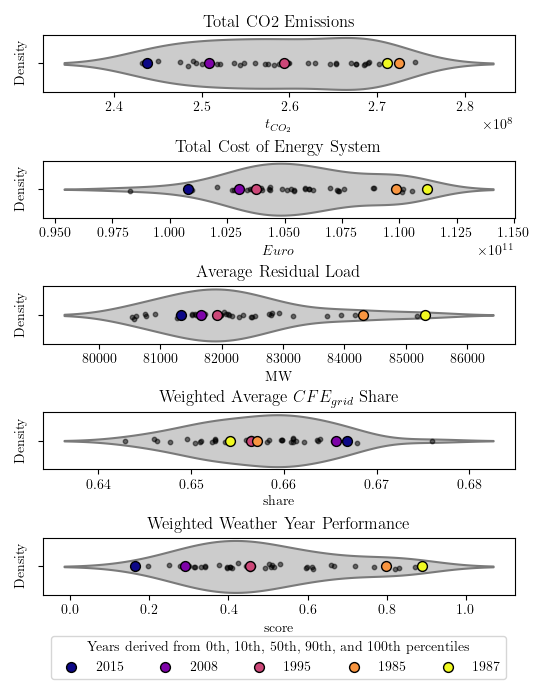

year     emissions     objective      rldc_sum  \
count    41.000000  4.100000e+01  4.100000e+01     41.000000   
mean   2000.000000  2.586992e+08  1.058037e+11  82202.297240   
std      11.979149  9.314511e+06  3.037114e+09   1169.222191   
min    1980.000000  2.431547e+08  9.828004e+10  80544.948080   
25%    1990.000000  2.508032e+08  1.037595e+11  81509.192892   
50%    2000.000000  2.588660e+08  1.054144e+11  82046.129837   
75%    2010.000000  2.675521e+08  1.075863e+11  82768.027688   
max    2020.000000  2.743862e+08  1.111921e+11  85309.953913   

       system_grid_cfe_wavg  emissions_weight  objective_weight  \
count             41.000000         41.000000         41.000000   
mean               0.657871          0.497719          0.582688   
std                0.006952          0.298241          0.235215   
min                0.642952          0.000000          0.000000   
25%                0.652611          0.244898          0.424365   
50%                0.658223          0.503058          0.552534   
75%                0.662183          0.781179          0.720739   
max                0.675943          1.000000          1.000000   

       rldc_sum_weight  system_grid_cfe_wavg_weight  weighted_score_weight  
count        41.000000                    41.000000              41.000000  
mean          0.347817                     0.547788               0.494003  
std           0.245377                     0.210726               0.189392  
min           0.000000                     0.000000               0.164788  
25%           0.202360                     0.417067               0.340696  
50%           0.315043                     0.537114               0.455601  
75%           0.466543                     0.707232               0.612477  
max           1.000000                     1.000000               0.888919

In [27]:
# Load data from CSV
df = pd.read_csv('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_pick.csv')

# Columns to plot, now including 'weighted_score_weight'
columns_to_plot = ['emissions', 'objective', 'rldc_sum', 'system_grid_cfe_wavg', 'weighted_score_weight']

# Rename dict for plot titles
rename_dict = {
    "emissions" : "Total CO2 Emissions",
    "objective" : "Total Cost of Energy System",
    "rldc_sum" : "Average Residual Load",
    "system_grid_cfe_wavg" : "Weighted Average $CFE_{grid}$ Share",
    "weighted_score_weight" : "Weighted Weather Year Performance"
}

# Rename dict for x-axis labels
renamevalue_dict = {
    "emissions" : "$t_{CO_2}$",
    "objective" : "$Euro$",
    "rldc_sum" : "MW",
    "system_grid_cfe_wavg" : "share",
    "weighted_score_weight" : "score"
}

# Calculate percentiles for 'weighted_score_weight' and find corresponding years
percentiles = [0, 0.1, 0.5, 0.9, 1.0]
percentile_values = df['weighted_score_weight'].quantile(percentiles)
percentile_years = [df.iloc[(df['weighted_score_weight'] - value).abs().argsort()[:1]]['year'].values[0] for value in percentile_values]

# Colormap for plotting
colormap = cm.get_cmap('plasma', len(percentile_years))
colors = [colormap(i) for i in range(len(percentile_years))]

# Set up the matplotlib figure
plt.figure(figsize=(5.45, 7))

# Create violin plots and overlay percentile data
for i, column in enumerate(columns_to_plot):
    plt.subplot(len(columns_to_plot), 1, i + 1)
    sns.violinplot(data=df, x=column, inner=None, color="0.8")  # inner=None removes quartile lines
    plt.scatter(x=df[column], y=np.random.normal(0, 0.02, size=len(df)), color='black', alpha=0.5, s=10)

    # Overlay percentiles
    for year, color in zip(percentile_years, colors):
        year_data = df[df['year'] == year][column]
        plt.scatter(year_data, [0]*len(year_data), color=color, s=50, edgecolor='k', label=f'{year}')

    # Apply renaming for titles and x-axis labels
    plt.title(rename_dict[column])
    plt.xlabel(renamevalue_dict[column])
    plt.ylabel('Density')

# Improve layout and add legend outside the plot
plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout
plt.subplots_adjust(bottom=0.15)  # Adjust subplot parameters to give some space for the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels/handles
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.5, -0.6), loc='upper center', title="Years derived from 0th, 10th, 50th, 90th, and 100th percentiles", ncols=5)

# Save the figure as a pgf file
plt.savefig('../plots/weather_year_performance_scenario1.pgf', format='pgf')

# Show the plot
plt.show()

df.describe()



## scen 1: deep dive rldc


/tmp/ipykernel_807519/324586890.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



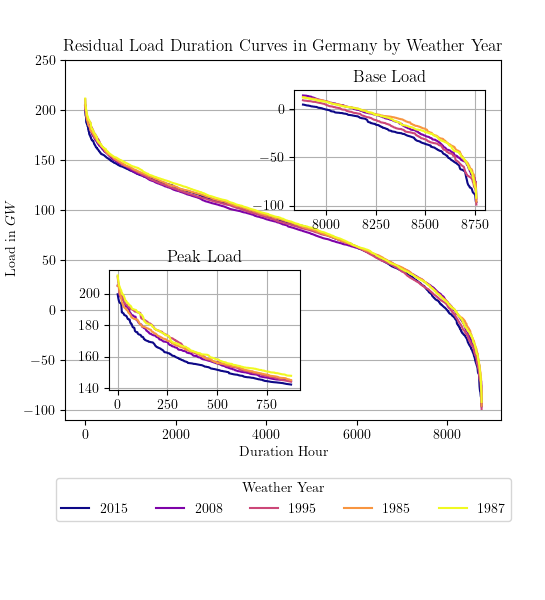

In [79]:
def plot_rldc_fromsummary(csvfile):
    # Load the CSV file into a DataFrame
    data = pd.read_csv(csvfile) 

    #specify node to plot
    node = 'DE1 0'
    
    # Sort data first by 'year' and then by 'variable' in descending order for proper curve plotting
    data.sort_values(by=['year', 'variable'], ascending=[True, False], inplace=True)
    
    # Get unique years from the 'year' column
    years = [2015, 2008, 1995, 1985, 1987]  # Assuming these are the years of interest
    
    # Colormap for plotting
    colormap = cm.get_cmap('plasma', len(years))
    colors = [colormap(i) for i in range(len(years))]
    
    # Set up the main plot
    fig = plt.figure(figsize=(5.45, 6))
    ax_main = fig.add_axes([0.12, 0.3, 0.8, 0.6])  # Main plot occupies the larger area
    
    # Subplots for peak and base load details
    ax_peak = fig.add_axes([0.2, 0.35, 0.35, 0.2])  # Bottom left quarter
    ax_base = fig.add_axes([0.54, 0.65, 0.35, 0.2])  # Top right quarter
    
    # Plot each year's residual load duration curve with assigned colors
    for idx, year in enumerate(years):
        yearly_data = data[data['year'] == year]
        
        # Main plot
        ax_main.plot(yearly_data['variable']*3, yearly_data[node].div(1e3), label=f'{year}', color=colors[idx])
        
        # Identify peak and base load areas
        peak_threshold = yearly_data[node].quantile(0.90)  # Top 10% loads
        base_threshold = yearly_data[node].quantile(0.10)  # Bottom 10%
        
        peak_data = yearly_data[yearly_data[node] >= peak_threshold]
        base_data = yearly_data[yearly_data[node] <= base_threshold]
        
        # Peak load subplot
        ax_peak.plot(peak_data['variable']*3, peak_data[node].div(1e3), color=colors[idx])
        
        # Base load subplot
        ax_base.plot(base_data['variable']*3, base_data[node].div(1e3), color=colors[idx])
    
    # Set titles and labels
    ax_main.set_title('Residual Load Duration Curves in Germany by Weather Year')
    ax_main.set_xlabel('Duration Hour')
    ax_main.set_ylabel('Load in $GW$')
    ax_main.set_ylim(-110, 250)
    ax_main.grid(True, which='major', axis='y')
    ax_main.legend(title='Weather Year', loc='lower center', bbox_to_anchor=(0.5, -0.30), ncol=5)
    
    ax_peak.set_title('Peak Load')
    ax_peak.grid(True)
    
    ax_base.set_title('Base Load')
    ax_base.grid(True)
    
    # Improve layout to avoid overlap
    plt.savefig('../plots/scen1_rldc.pgf', format='pgf')
    plt.show()


plot_rldc_fromsummary('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_rldc.csv')

/home/tillotillson/miniforge3/envs/247-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_716047/1138187981.py:34: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



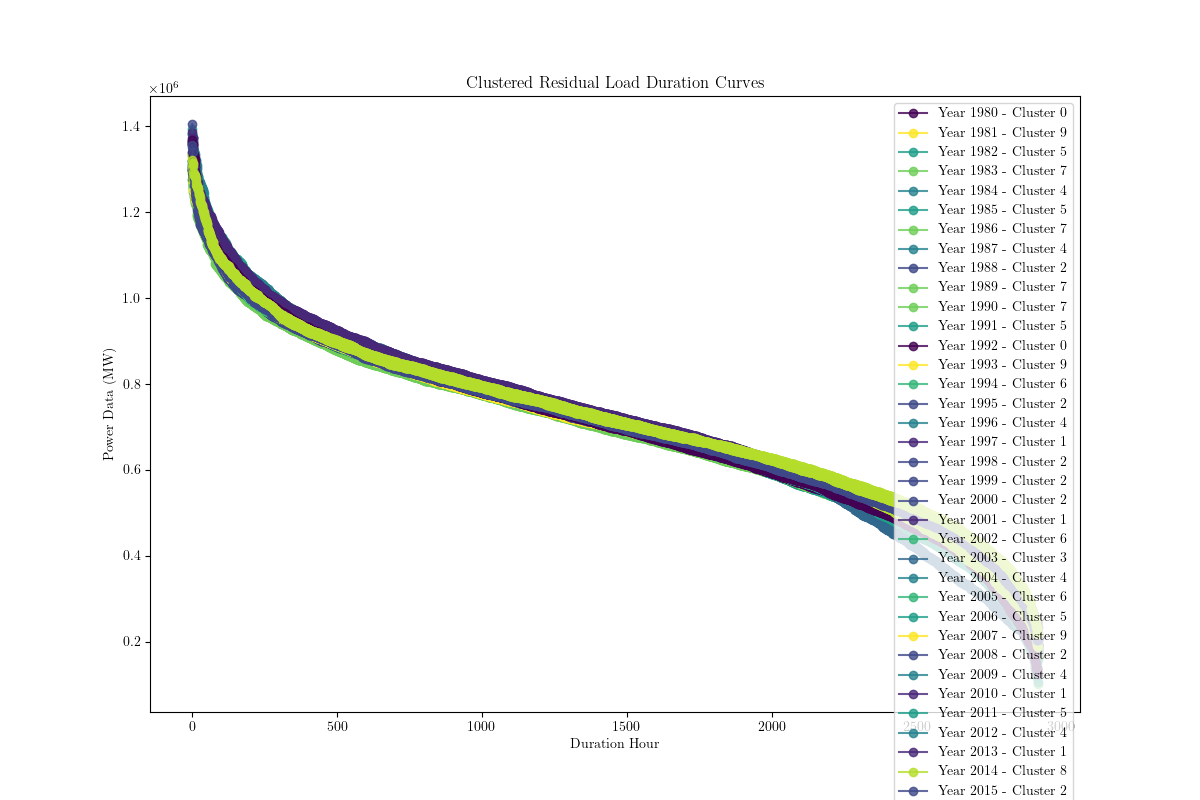

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_and_plot_load_duration(csv_file, n_clusters=3):
     # Load the CSV file into a DataFrame
    data = pd.read_csv(csv_file)
    
    # Sort data by 'year' and then by 'variable' in descending order
    data.sort_values(by=['year', 'variable'], ascending=[True, False], inplace=True)
    
    # Prepare data for clustering
    years = data['year'].unique()
    features = []
    
    for year in years:
        yearly_data = data[data['year'] == year]
        # Ensure all vectors have the same length if 'variable' steps differ between years
        # Interpolation could be used here if necessary
        features.append(yearly_data['total'].tolist())
    
    # Standardize features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    # Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(features)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    color_palette = plt.cm.get_cmap('viridis', n_clusters)  # Get a color map for n_clusters
    
    for idx, year in enumerate(years):
        cluster = clusters[idx]
        yearly_data = data[data['year'] == year]
        plt.plot(yearly_data['variable'], yearly_data['total'], marker='o', alpha=0.8, color=color_palette(cluster),
                 label=f'Year {year} - Cluster {cluster}')

    # Create a legend for clusters
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Removing duplicates in legend
    plt.legend(by_label.values(), by_label.keys())
    
    plt.title('Clustered Residual Load Duration Curves')
    plt.xlabel('Duration Hour')
    plt.ylabel('Power Data (MW)')
    plt.show()
# Example usage
cluster_and_plot_load_duration('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_rldc.csv', n_clusters=10)


## scen 1: installed capacities in 5 wy


/tmp/ipykernel_18418/2530147468.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



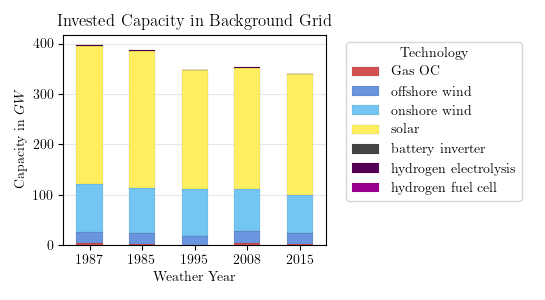

technology  Gas OC  offshore wind  onshore wind   solar  battery inverter  \
year                                                                        
1985          1.42          23.40         87.92  273.44               0.0   
1987          3.77          22.06         95.20  274.78               0.0   
1995          0.86          17.90         91.86  236.24               0.0   
2008          4.98          22.38         84.63  239.73               0.0   
2015          1.44          21.78         77.22  238.87               0.0   

technology  hydrogen electrolysis  hydrogen fuel cell  
year                                                   
1985                         1.01                0.42  
1987                         1.19                0.44  
1995                         1.01                0.37  
2008                         1.22                0.44  
2015                         0.69                0.24

In [9]:
df = pd.read_csv('../results/04_21-EU_DE_scenario_1/csvs/10/2025/DE/p1/summary_weather_years.csv')
selected_years = [1987, 1985, 1995, 2008, 2015]
df_filtered = df[df['year'].isin(selected_years) & df['variable'].str.contains('system_inv_')]

# Applying the rename mapping to the 'variable' column
df_filtered.loc[:,'technology'] = df_filtered['variable'].replace(rename_system_simple, regex=True)

# Grouping the data by year and technology for the investment sum
investment_data = df_filtered.groupby(['year', 'technology'])['ref'].sum().unstack(fill_value=0)


# Reorder the columns according to the preferred order while ensuring all desired technologies are listed
investment_data = investment_data[[tech for tech in preferred_order if tech in investment_data.columns]]
# Reorder the rows according to the selected years
investment_data_sorted = investment_data.loc[selected_years]


# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(5.45, 3))
(investment_data_sorted/1e3).plot(kind='bar', stacked=True, color=[tech_colors.get(x) for x in investment_data_sorted.columns], ax=ax, edgecolor="black", linewidth=0.05, zorder=10)
ax.set_title('Invested Capacity in Background Grid')
ax.set_ylabel('Capacity in $GW$')
ax.set_xlabel('Weather Year')
plt.xticks(rotation=0)
ax.grid(alpha=0.3, axis='y')
ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.savefig('../plots/system_investment_selected_years.pgf', format='pgf')
plt.show()

investment_data.div(1e3).round(2)

# scen 2: plot cost, generation and capacity and cfe share

## scen 2: cost and revenue

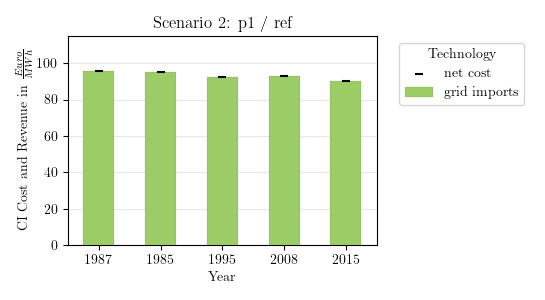

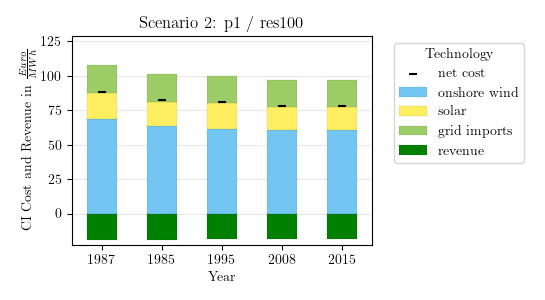

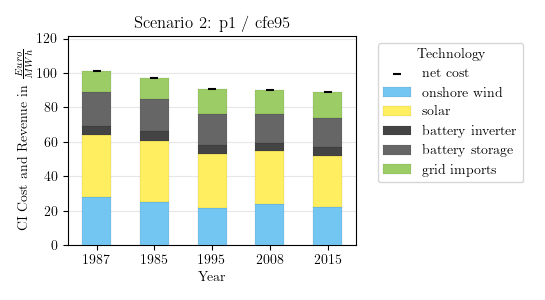

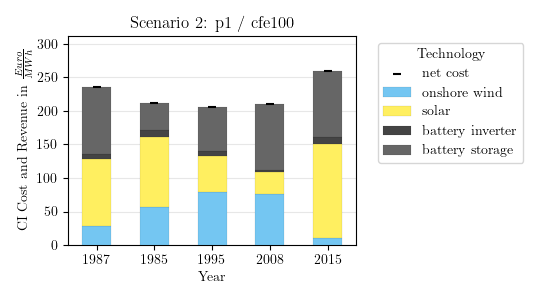

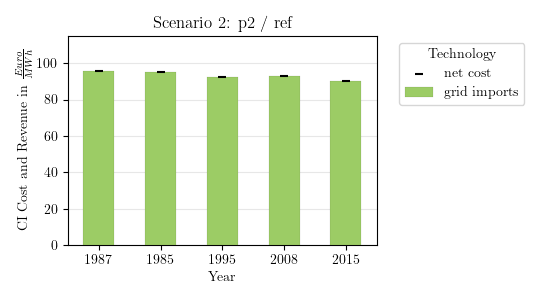

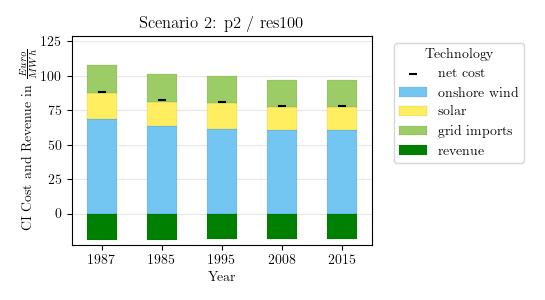

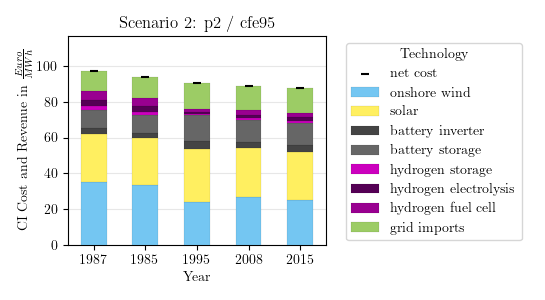

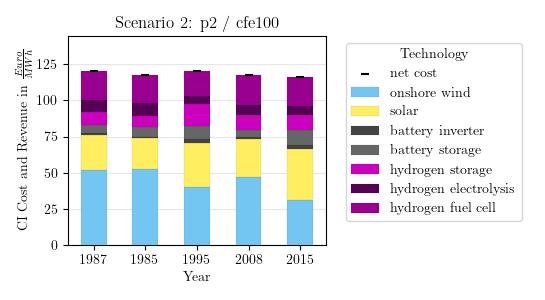

In [4]:
def ci_costnrev(df, scenario ,selected_years):
        # Filter DataFrame for selected years and necessary variables
    df = df[df['year'].isin(selected_years)]

    # Filter for cost-related rows and the total demand
    cost_rows = df[df['variable'].str.startswith('ci_cost')].copy()
    demand_data = df[df['variable'] == 'ci_demand_total'].copy()
    revenue_data = df[df['variable'] == 'ci_average_revenue'].copy()
    revenue_data[scenario] = -revenue_data[scenario]

    # Normalize costs by total demand for each year
    for year in cost_rows['year'].unique():
        total_demand = demand_data[demand_data['year'] == year][scenario].values[0]
        cost_rows.loc[cost_rows['year'] == year, scenario] /= total_demand

    #clean up data
    cost_rows['variable'] = cost_rows['variable'].str.replace('ci_cost_', '').map(rename_ci_cost)  # Clean up variable names
    revenue_data['variable'] = 'revenue'
    cost_rows = pd.concat([cost_rows, revenue_data])

    # Pivot the table for easier plotting
    plot_data = cost_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns according to the preferred order. technologies not listed in the preferred order will be appended at the end
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in preferred_order]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    # Plotting
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=3)

    #set marker for net cost
    netc=plot_data.sum(axis=1)
    ax.scatter(range(len(netc)), netc.values, color='black', marker='_', label='net cost', zorder=11)

    #Layout
    ax.set_ylabel(r"CI Cost and Revenue in $\frac{Euro}{MWh}$")
    ax.set_ylim(plot_data[plot_data < 0].sum(axis=1).min()*1.2, plot_data[plot_data > 0].sum(axis=1).max()*1.2)
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left', ncols=1)
    ax.set_title(f'Scenario 2: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_2_ci_cost_revenue_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['ref', 'res100', 'cfe95', 'cfe100']
for pal in palette:
    df = pd.read_csv(f'../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        ci_costnrev(df, pol, selected_years)

# Example of how to call this function with your DataFrame `df` and the list of selected years
#ci_costnrev(df, 'cfe100', [1987, 1985, 1995, 2008, 2015])


## scen 2: generation

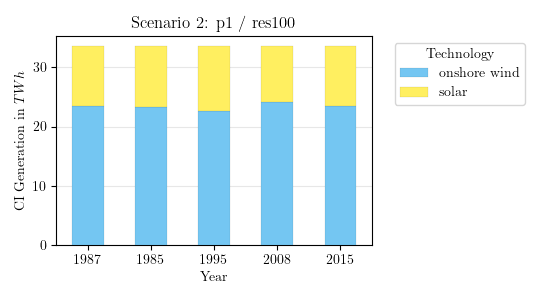

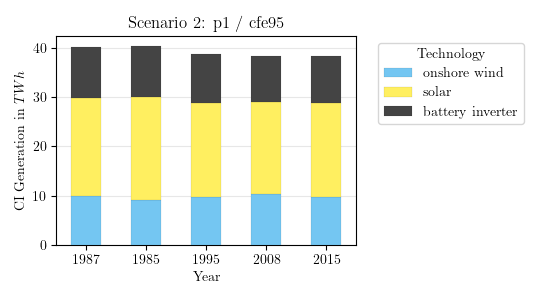

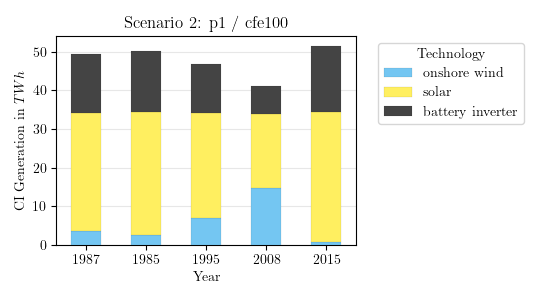

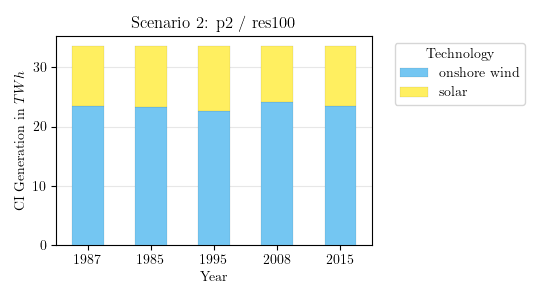

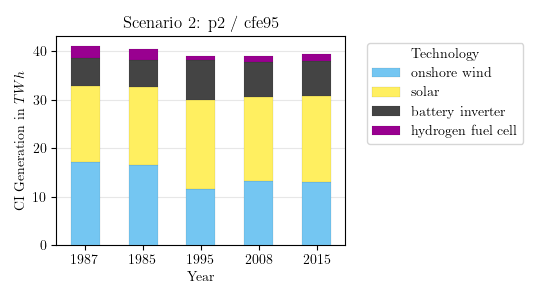

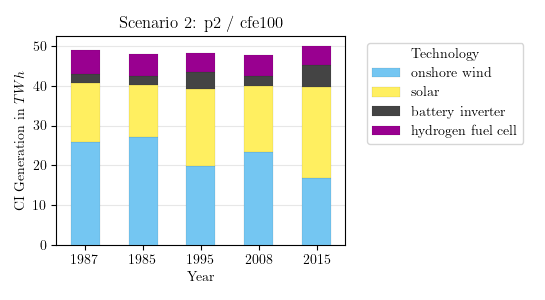

In [41]:

def plot_generation_volume(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Filter for generation-related rows
    generation_rows = df[df['variable'].str.startswith('ci_generation_')].copy()

    # Normalize generation volumes by dividing by 1000 (e.g., converting MWh to TWh)
    generation_rows[scenario] = generation_rows[scenario] / 1000000.0

    # Rename variables using the provided dictionary
    generation_rows['variable'] = generation_rows['variable'].str.replace('ci_generation_', '').replace(rename_ci_capacity)

    # Pivot the table for easier plotting
    plot_data = generation_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=10)
    ax.set_ylabel("CI Generation in $TWh$")
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'Scenario 2: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_2_ci_generation_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['res100', 'cfe95', 'cfe100']
for pal in palette:
    df = pd.read_csv(f'../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        plot_generation_volume(df, pol, selected_years)

## scen 2: capacity

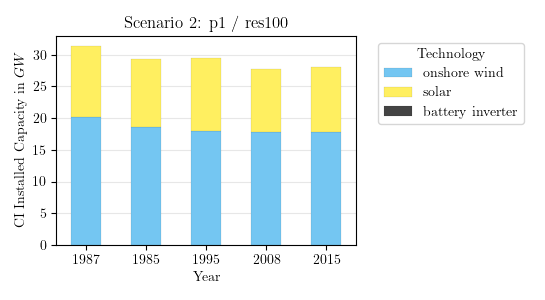

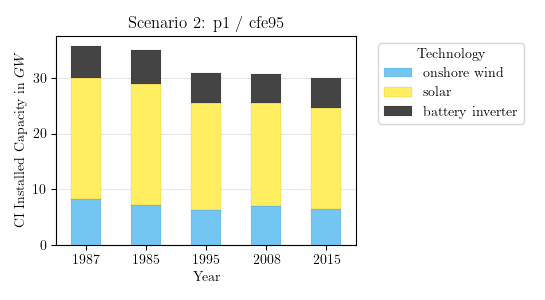

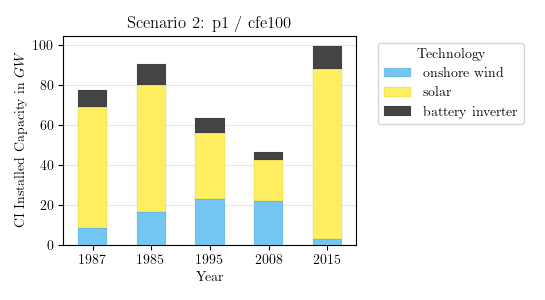

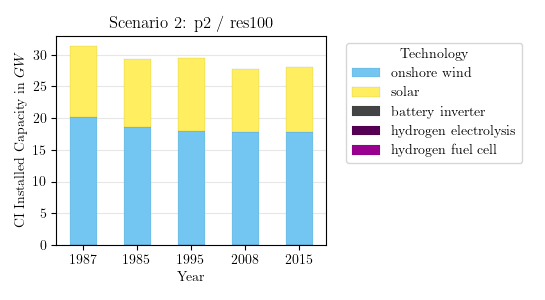

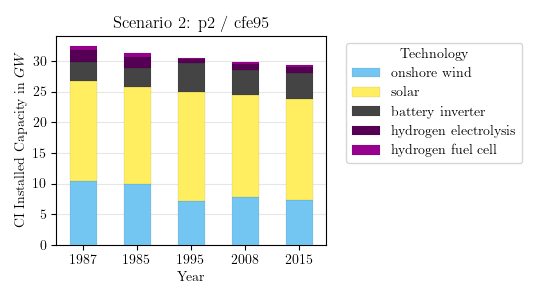

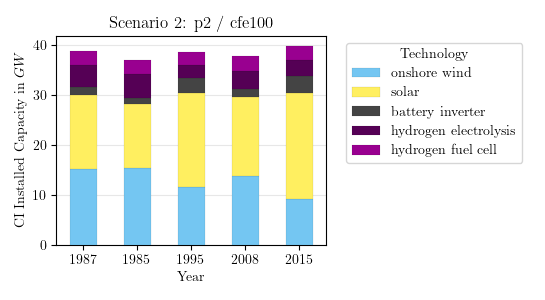

In [36]:
def plot_capacity_over_years(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Filter for capacity-related rows
    capacity_rows = df[df['variable'].str.startswith('ci_cap_')].copy()

    # Apply renaming to match the provided dictionary
    capacity_rows['variable'] = capacity_rows['variable'].str.replace('ci_cap_', '').replace(rename_ci_capacity)
    #drop battery_charger from capacity_rows
    capacity_rows = capacity_rows[~capacity_rows['variable'].str.contains('battery_charger')]

    # Pivot the table for easier plotting
    plot_data = capacity_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years and convert to GW
    plot_data = plot_data.loc[selected_years] / 1000

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=10)
    ax.set_ylabel("CI Installed Capacity in $GW$")
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'Scenario 2: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_2_ci_capacity_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['res100', 'cfe95', 'cfe100']
for pal in palette:
    df = pd.read_csv(f'../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        plot_capacity_over_years(df, pol, selected_years)

## scen2: cfe share

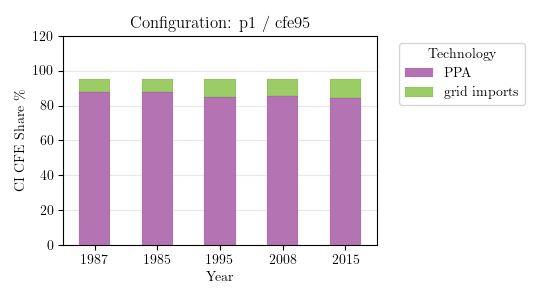

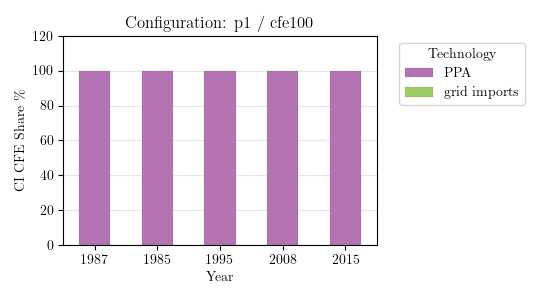

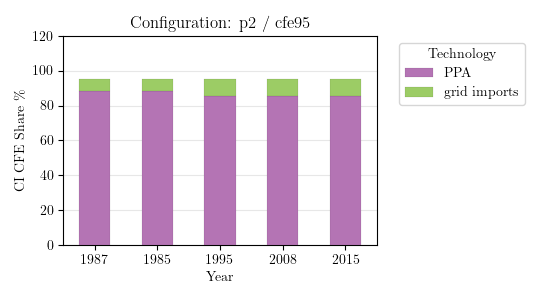

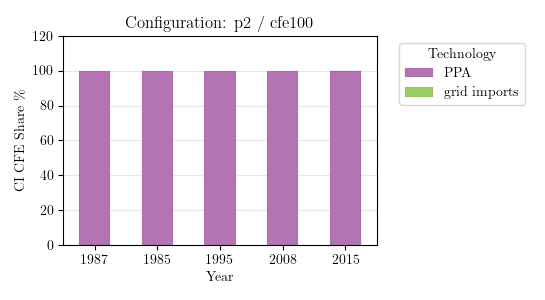

In [22]:
def plot_cfe_share(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Define types to plot and construct variable names
    types = ["local", "grid"]
    variable_names = [f"ci_fraction_clean_used_{t}" for t in types]

    # Filter for CFE share-related rows
    cfe_share_rows = df[df['variable'].isin(variable_names)].copy()

    # Rename using a dictionary comprehension and further mappings
    cfe_share_rows['variable'] = cfe_share_rows['variable'].map(
        {f"ci_fraction_clean_used_{t}": t for t in types}
    ).replace({"local": "PPA", "grid": "grid imports"})

    # Pivot the table for easier plotting
    plot_data = cfe_share_rows.pivot(index='year', columns='variable', values=scenario)

    # Convert to percentages and round
    plot_data = (100 * plot_data).round(1)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors,edgecolor="black", linewidth=0.05,  zorder=10)
    ax.set_ylabel("CI CFE Share $\%$")
    ax.set_xlabel('Year')
    ax.set_ylim(0, 120)
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'Configuration: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_2_ci_cfe_share_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['cfe95', 'cfe100'] #'ref','res100', 
for pal in palette:
    df = pd.read_csv(f'../results/04_21-EU_DE_scenario_2/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        plot_cfe_share(df, pol, selected_years)

## scen 2: map with capacity factors

INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


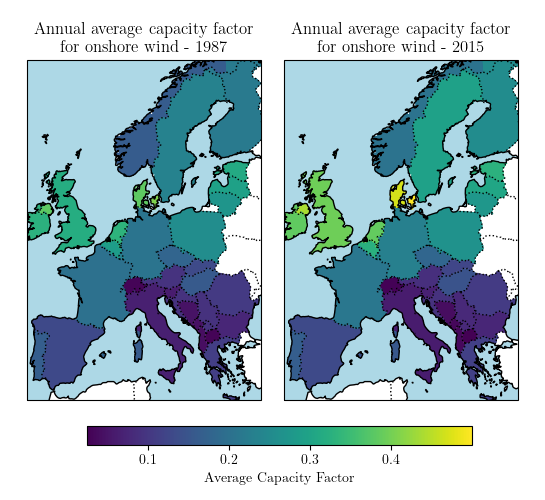

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pypsa

def prepare_capacity_factor_data(network, carrier):
    """Prepare capacity factor data from the network object."""
    carrier_data = network.generators_t.p_max_pu.filter(like=carrier).mean()
    return carrier_data.rename(lambda x: " ".join(x.split()[:-1])).to_frame("average_capacity_factor")

def plot_comparison_capacity_factors(regions, year1, year2, carrier):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5.45, 5), subplot_kw={'projection': ccrs.PlateCarree()})

    #load networks
    network1_data = pypsa.Network(f'../results/04_21-EU_DE_scenario_1/networks/10/2025/DE/p1/{year1}/ref.nc')
    network2_data = pypsa.Network(f'../results/04_21-EU_DE_scenario_1/networks/10/2025/DE/p1/{year2}/ref.nc')

    # Define colormap based on the carrier type
    colormaps = {
        "onwind": "viridis",
        "solar": "cividis"
    }
    colormap = colormaps.get(carrier, "viridis")
    if carrier == "onwind":
        label = "onshore wind"
    elif carrier == "solar":
        label = "solar PV"

    # Prepare data for each network
    network1_prepared = prepare_capacity_factor_data(network1_data, carrier)
    network2_prepared = prepare_capacity_factor_data(network2_data, carrier)

    # Determine global min and max for color normalization
    vmin = min(network1_prepared['average_capacity_factor'].min(), network2_prepared['average_capacity_factor'].min())
    vmax = max(network1_prepared['average_capacity_factor'].max(), network2_prepared['average_capacity_factor'].max())

    def plot_map(ax, data, regions, title_suffix):
        """Helper function to plot each map."""
        merged_regions = regions.merge(data, left_on="name", right_index=True, how="left")
        ax.set_extent([-10, 30, 35, 70], ccrs.PlateCarree())
        ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
        ax.add_feature(cfeature.LAND, facecolor="white")
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.COASTLINE)
        merged_regions.plot(column='average_capacity_factor', ax=ax, legend=False, cmap=colormap, vmin=vmin, vmax=vmax)
        ax.set_title(title_suffix, fontsize=12)

    # Plot data for each network scenario
    plot_map(ax1, network1_prepared, regions, f"Annual average capacity factor\nfor {label} - {year1}")
    plot_map(ax2, network2_prepared, regions, f"Annual average capacity factor\nfor {label} - {year2}")

    # Create one colorbar for both plots
    sm = mpl.cm.ScalarMappable(cmap=colormap, norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=5,)
    cbar.set_label('Average Capacity Factor')

    plt.subplots_adjust(top=0.95, bottom=0.2, left=0.05, right=0.95, hspace=0.1, wspace=0.1)
    #plt.tight_layout()
    plt.savefig(f'../plots/capacity_factor_comparison_{carrier}_{year1}_{year2}.pdf', format='pdf')
    plt.show()

y1 = 1987 # 1987 worst wy
y2 = 2015 # 2015 best wy
carrier = "onwind" #solar or onwind

regions = gpd.read_file("../input/regions_onshore_elec_s_37.geojson")

plot_comparison_capacity_factors(regions, y1, y2, carrier)

## scen 2: shadow prices/system cost heat map

INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network ref.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


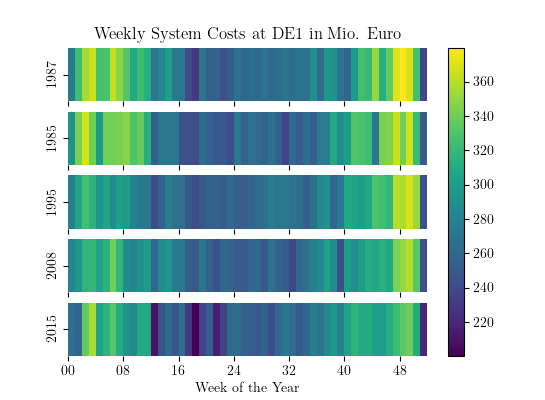

In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa

def plot_network_costs(years, resampling='D'):
    # Check if we have exactly 5 networks
    if len(years) != 5:
        raise ValueError("Exactly 5 years are required.")
    
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5.45, 4), sharex=True)
    
    # For consistent color scaling across all subplots, determine global min and max
    global_min, global_max = float('inf'), float('-inf')
    
    costs_list = []  # List to hold the cost data for all networks

    for i, y in enumerate(years):
        n = pypsa.Network(f'../results/04_21-EU_DE_scenario_2/networks/10/2025/DE/p1/{y}/ref.nc')
        # Extract shadow prices and load timeseries for node 'DE1 0'
        shadow_price = n.buses_t.marginal_price.loc[:, 'DE1 0']
        load = n.loads_t.p_set.loc[:, 'DE1 0'] if 'DE1 0' in n.loads_t.p_set.columns else pd.Series(0, index=n.snapshots)
        
        # Calculate hourly system cost
        hourly_costs = shadow_price * load
        
        # Sum costs into specified resampling length
        daily_costs = hourly_costs.resample(resampling).sum() / 1e6  # Convert to Mio. Euro
        daily_costs.index = daily_costs.index.strftime('%W')  # Formatting the date
        #sum weeks 0
        daily_costs = daily_costs.groupby(daily_costs.index).sum()

        # Update global min and max
        min_cost, max_cost = daily_costs.min(), daily_costs.max()
        global_min, global_max = min(global_min, min_cost), max(global_max, max_cost)
        
        costs_list.append(daily_costs.to_frame(f'{y}'))

    # Normalize and plot each subplot
    for ax, daily_costs in zip(axes.flatten(), costs_list):
        sns.heatmap(daily_costs.T, ax=ax, cmap='viridis', cbar=False, vmin=global_min, vmax=global_max)
        ax.set_xlabel('')

    axes[0].set_title('Weekly System Costs at DE1 in Mio. Euro')
    axes[4].set_xlabel('Week of the Year')
    # Add one color bar for all subplots on the right side of the figure
    fig.colorbar(ax.collections[0], ax=axes, orientation='vertical', fraction=.1)
    plt.xticks(ticks=range(0, len(daily_costs), 8), labels=daily_costs.index[::8])
    #plt.tight_layout()
    plt.savefig('../plots/network_costs_heatmap.pdf', format='pdf')
    plt.show()

# Example usage
years = [1987, 1985, 1995, 2008, 2015]
plot_network_costs(years, resampling='W') #D for daily, W for weekly


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


KeyboardInterrupt: 

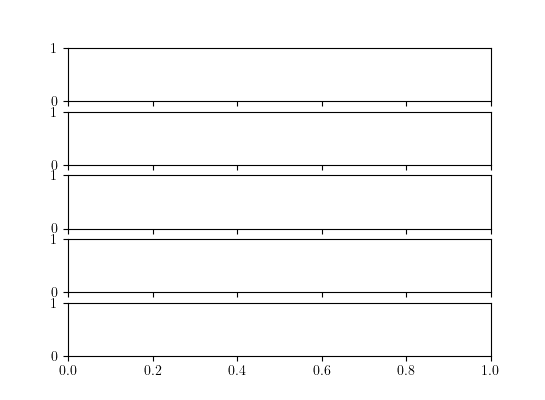

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pypsa

def plot_network_costs(years, node='DE1 0', policy='cfe95', palette='p1',resampling='D'):
    # Check if we have exactly 5 networks
    if len(years) != 5:
        raise ValueError("Exactly 5 years are required.")
    
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5.45, 4), sharex=True)
    
    # For consistent color scaling across all subplots, determine global min and max
    global_min, global_max = float('inf'), float('-inf')
    
    costs_list = []  # List to hold the cost data for all networks

    for i, y in enumerate(years):
        n = pypsa.Network(f'../results/04_21-EU_DE_scenario_2/networks/10/2025/DE/{palette}/{y}/{policy}.nc')
        # Extract shadow prices and load timeseries for node
        shadow_price = n.buses_t.marginal_price.loc[:, node] 
        load = pd.Series(1, index=n.snapshots)
        
        # Calculate hourly system cost
        hourly_costs = shadow_price * load
        
        # Sum costs into specified resampling length
        daily_costs = hourly_costs.resample(resampling).mean()  # resample to average
        full_weeks = hourly_costs.resample('7D').count() == 56
        daily_costs = daily_costs[full_weeks] # drop weeks with less than 7 days
        daily_costs.index = daily_costs.index.strftime('%W')  # Formatting the date
        #daily_costs = daily_costs.groupby(daily_costs.index).sum() # add first and last 0 week

        print(f"{y}: {daily_costs.max()}")

        # Update global min and max
        min_cost, max_cost = daily_costs.min(), daily_costs.max()
        global_min, global_max = min(global_min, min_cost), max(global_max, max_cost)
        
        costs_list.append(daily_costs.to_frame(f'{y}'))

    # Normalize and plot each subplot
    for ax, daily_costs in zip(axes.flatten(), costs_list):
        sns.heatmap(daily_costs.T, ax=ax, cmap='viridis', cbar=False, vmin=global_min, vmax=global_max)
        ax.set_xlabel('')
    dict = { 'DE1 0': 'German', 'google': 'C\&I'}
    axes[0].set_title(f'Weekly Average Shadow Prices at {dict.get(node)} Node in '+r'$\frac{Euro}{MWh}$')
    axes[4].set_xlabel('Week of the Year')
    # Add one color bar for all subplots on the right side of the figure
    fig.colorbar(ax.collections[0], ax=axes, orientation='vertical', fraction=.1)
    plt.xticks(ticks=range(0, len(daily_costs), 8), labels=daily_costs.index[::8])
    #plt.tight_layout()
    plt.savefig(f'../plots/network_prices_heatmap_{node}_{policy}_{palette}.pdf', format='pdf')
    plt.show()

# Example usage
years = [1987, 1985, 1995, 2008, 2015]
node = 'DE1 0' # DE1 0 or google
policy = 'cfe100' # cfe100
palette = 'p2'
plot_network_costs(years,  node, policy, palette, resampling='7D',) #D for daily, W for weekly


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


1987: 447.79700221798953


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


1985: 508.30979413402275


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


1995: 376.7411888832584


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


2008: 375.82967362147923


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


2015: 414.95613974852904


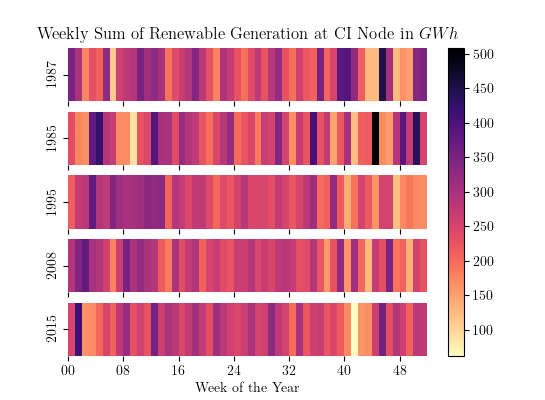

In [30]:
def plot_renewable_generation(years, node='DE1 0', palette='p1', policy='cfe95', resampling='W'):
    # Check if we have exactly 5 years
    if len(years) != 5:
        raise ValueError("Exactly 5 years are required.")
    
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5.45, 4), sharex=True)
    
    # For consistent color scaling across all subplots, determine global min and max
    global_min, global_max = float('inf'), float('-inf')
    
    generation_list = []  # List to hold the generation data for all networks

    for i, y in enumerate(years):
        n = pypsa.Network(f'../results/04_21-EU_DE_scenario_2/networks/10/2025/DE/{palette}/{y}/{policy}.nc')
        
        # Filter generators that are at the specified node and include 'onwind' or 'solar' in their names
        filtered_generators = [gen for gen in n.generators.index
                               if node in n.generators.loc[gen, 'bus'] and
                               ('onwind' in gen or 'solar' in gen)]
        
        # Sum the generation for the filtered generators
        total_generation = n.generators_t.p.loc[:, filtered_generators].sum(axis=1)
        
        # Sum costs into specified resampling length
        resampled_generation = total_generation.resample(resampling).sum()/1000  # resample to sum
        full_weeks = total_generation.resample('7D').count() == 56
        resampled_generation = resampled_generation[full_weeks] # drop weeks with less than 7 days
        resampled_generation.index = resampled_generation.index.strftime('%W')  # Formatting the date

        #if resampling == 'W':
        #    resampled_generation = resampled_generation.groupby(resampled_generation.index).sum()/1000 # add first and last 0 week
            

        print(f"{y}: {resampled_generation.max()}")

        # Update global min and max
        min_gen, max_gen = resampled_generation.min(), resampled_generation.max()
        global_min, global_max = min(global_min, min_gen), max(global_max, max_gen)
        
        generation_list.append(resampled_generation.to_frame(f'{y}'))

    # Normalize and plot each subplot
    for ax, generation_data in zip(axes.flatten(), generation_list):
        sns.heatmap(generation_data.T, ax=ax, cmap='magma_r', cbar=False, vmin=global_min, vmax=global_max)
        ax.set_xlabel('')

    axes[0].set_title(f'Weekly Sum of Renewable Generation at CI Node in $GWh$')
    axes[-1].set_xlabel('Week of the Year')
    # Add one color bar for all subplots on the right side of the figure
    fig.colorbar(ax.collections[0], ax=axes, orientation='vertical', fraction=.1)
    plt.xticks(ticks=range(0, len(resampled_generation), 8), labels=resampled_generation.index[::8])
    #plt.tight_layout()
    plt.savefig(f'../plots/renewable_generation_heatmap_{node}_{policy}_{palette}.pdf', format='pdf')
    plt.show()

# Example usage
years = [1987, 1985, 1995, 2008, 2015]
node = 'google'
palette = 'p2'
policy = 'cfe100'
plot_renewable_generation(years, node, palette, policy, resampling='7D') # W for weekly


## scen 2: power bus google  

INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


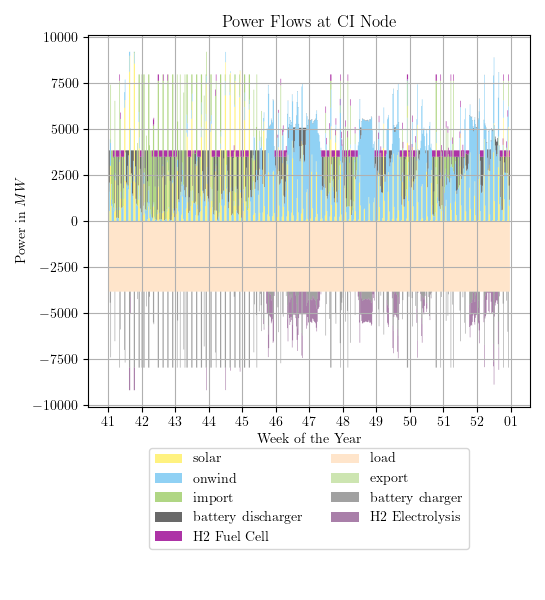

In [62]:
import matplotlib.dates as mdates

def plot_power(path, weeks_of_year):
    network = pypsa.Network(path)
    # Convert snapshots to datetime to filter by weeks
    network.snapshots = pd.to_datetime(network.snapshots)
    week_mask = network.snapshots.isocalendar().week.isin(weeks_of_year)
    time = network.snapshots[week_mask]

    color = {
        'solar' : '#ffef60',
        'onwind' : '#74c6f2',
        'load': '#ffcc99',
        'load shedding': 'red',
        'import': '#9ccc65',
        'export': '#9ccc65',
        'battery discharger': '#444444',
        'battery charger': '#444444',
        'H2 Electrolysis': '#550055',
        'H2 Fuel Cell': '#990090',
    }

    pos = ['solar', 'onwind', 'import', 'battery discharger', 'H2 Fuel Cell']
    neg = ['load', 'load shedding', 'export', 'battery charger', 'H2 Electrolysis']
    
    # Collect positive and negative data
    pos_data = {}
    neg_data = {}

    for item in pos:
        full_name = 'google ' + item
        if full_name in network.generators_t.p.columns:
            pos_data[item] = network.generators_t.p[full_name][week_mask]
        elif full_name in network.links_t.p1.columns:
            pos_data[item] = -network.links_t.p1[full_name][week_mask]
    
    for item in neg:
        full_name = 'google ' + item
        if full_name in network.loads_t.p_set.columns:
            neg_data[item] = -network.loads_t.p_set[full_name][week_mask]
        elif full_name in network.links_t.p0.columns:
            neg_data[item] = -network.links_t.p0[full_name][week_mask]
        elif full_name in network.generators_t.p.columns and item == 'load shedding':
            # Special case: load shedding is implemented as a generator but plotted as negative
            neg_data[item] = -network.generators_t.p[full_name][week_mask]
            #subtract load shedding from load
            neg_data['load'] -= neg_data[item]


    plt.figure(figsize=(5.45, 6))
        # Plotting positive contributions
    plt.stackplot(time, pos_data.values(), step='post', labels=[item for item in pos_data.keys()], colors=[color[item] for item in pos_data.keys()], alpha=0.8)
    # Plotting negative contributions
    plt.stackplot(time, neg_data.values(), step='post', labels=[item for item in neg_data.keys()], colors=[color[item] for item in neg_data.keys()], alpha=0.5)

    plt.title('Power Flows at CI Node')
    plt.ylabel('Power in $MW$')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)
    plt.grid(True)


    # Set the locator to weekly
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

    # Set the formatter to display the week number
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%V'))

    # Set x-label for the bottom plot
    plt.xlabel('Week of the Year')


    # Show plot
    plt.tight_layout()
    palette = path.split('/')[-3]
    year = path.split('/')[-2]
    policy = path.split('/')[-1].split('.')[0]
    plt.savefig(f'../plots/power_flows_{palette}_{year}_{policy}.pgf', format='pgf')
    plt.show()

n = "../results/04_21-EU_DE_scenario_2/networks/10/2025/DE/p2/2015/cfe95.nc" #"../results/04_22-EU_DE_scenario_3/networks/10/2025/DE/p2/1987/cfe100.nc"
plot_power(n, [i for i in range(41, 53)]) # specify interval of weeks of the year to plot

# scen 3: operational challenges

## scen3: cost and revenue

INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


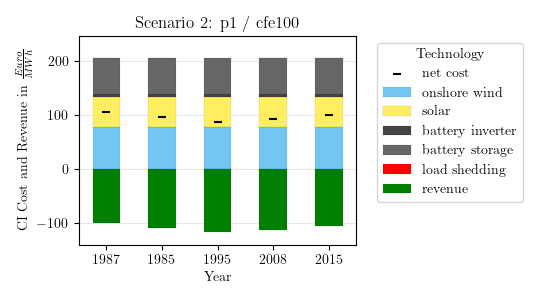

INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


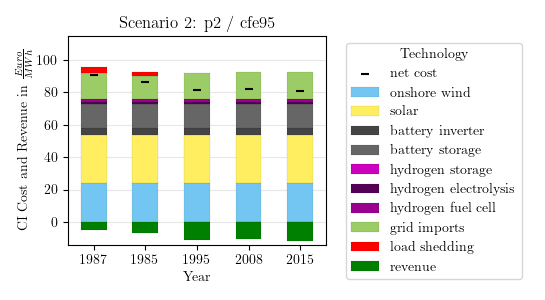

INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


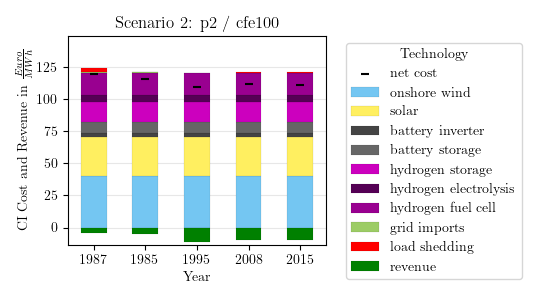

In [61]:
def ci_costnrev_scen3(df, scenario ,selected_years, network_path):
    # Filter DataFrame for selected years and necessary variables
    df = df[df['year'].isin(selected_years)]

    # Filter for cost-related rows and the total demand
    cost_rows = df[df['variable'].str.startswith('ci_cost')].copy()
    demand_data = df[df['variable'] == 'ci_demand_total'].copy()
    revenue_data = df[df['variable'] == 'ci_average_revenue'].copy()
    revenue_data[scenario] = -revenue_data[scenario]

    # get marginal prices for load shedding / grid imports + penalty
    ls_cost = df[df['variable'] == 'ci_generation_load_shedding'].copy() 
    ls_cost['variable'] = 'ci_cost_load_shedding'
    for year in selected_years:
        n = pypsa.Network(f'{network_path}/{year}/{scenario}.nc')
        # Extract shadow prices and load timeseries for node 'DE1 0'
        shadow_price = n.buses_t.marginal_price.loc[:, 'DE1 0']
        costs = n.generators_t.p["google load shedding"].multiply(n.snapshot_weightings["generators"],axis=0)*shadow_price
        costs = costs[costs > 0.1].add(40.2) # add 80 Euro/t_CO2 ETS allowance equals 40.2 Euro/MWh with a OCGT efficiency of 40% and emissionalty of 0.201 T_CO2/MWh
        costs = costs.sum()
        ls_cost.loc[ls_cost['year'] == year, scenario] = costs

    cost_rows = pd.concat([cost_rows, ls_cost])

    # Normalize costs by total demand for each year
    for year in cost_rows['year'].unique():
        total_demand = demand_data[demand_data['year'] == year][scenario].values[0]
        cost_rows.loc[cost_rows['year'] == year, scenario] /= total_demand

    #clean up data
    cost_rows['variable'] = cost_rows['variable'].str.replace('ci_cost_', '').map(rename_ci_cost)  # Clean up variable names
    revenue_data['variable'] = 'revenue'
    cost_rows = pd.concat([cost_rows, revenue_data])

    # Pivot the table for easier plotting
    plot_data = cost_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns according to the preferred order. technologies not listed in the preferred order will be appended at the end
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in preferred_order]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    # Plotting
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=3)

    #set marker for net cost
    netc=plot_data.sum(axis=1)
    ax.scatter(range(len(netc)), netc.values, color='black', marker='_', label='net cost', zorder=11)

    #Layout
    ax.set_ylabel(r"CI Cost and Revenue in $\frac{Euro}{MWh}$")
    ax.set_ylim(plot_data[plot_data < 0].sum(axis=1).min()*1.2, plot_data[plot_data > 0].sum(axis=1).max()*1.2)
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left', ncols=1)
    ax.set_title(f'Scenario 2: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_3_ci_cost_revenue_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['cfe95', 'cfe100']
run = '04_26-EU_DE_scenario_3_imports'
for pal in palette:
    df = pd.read_csv(f'../results/{run}/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    network_path = f'../results/{run}/networks/10/2025/DE/{pal}/'
    for pol in policy:
        ci_costnrev_scen3(df, pol, selected_years, network_path)

# Example of how to call this function with your DataFrame `df` and the list of selected years
#ci_costnrev(df, 'cfe100', [1987, 1985, 1995, 2008, 2015])


## scen3: generation


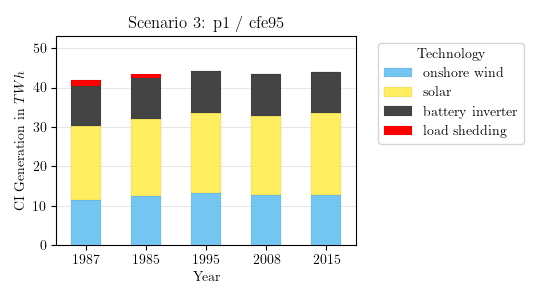

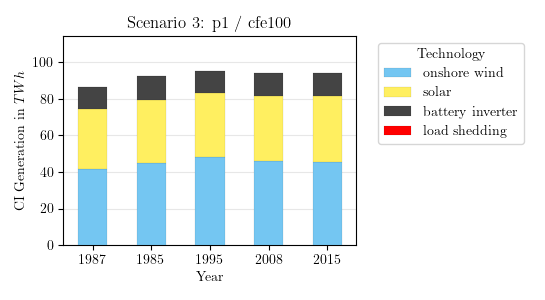

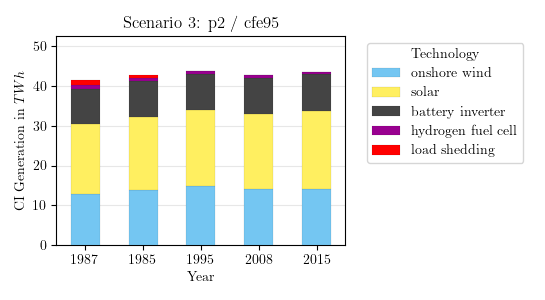

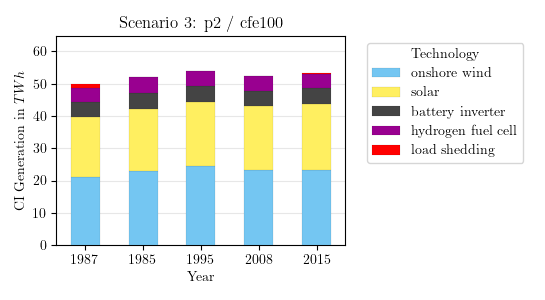

In [62]:
def plot_generation_volume_scen3(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Filter for generation-related rows
    generation_rows = df[df['variable'].str.startswith('ci_generation_')].copy()

    # Normalize generation volumes by dividing by 1000 (e.g., converting MWh to TWh)
    generation_rows[scenario] = generation_rows[scenario] / 1000000.0

    # Rename variables using the provided dictionary
    generation_rows['variable'] = generation_rows['variable'].str.replace('ci_generation_', '').replace(rename_ci_capacity)

    # Pivot the table for easier plotting
    plot_data = generation_rows.pivot(index='year', columns='variable', values=scenario)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    #drop empty columns
    to_drop = plot_data.columns[(plot_data.abs() < 0.1).all(axis=0)]
    plot_data.drop(to_drop, axis=1, inplace=True)

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))

    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05, zorder=10)
    # Calculate the maximum of the summed values (total height of each stacked bar)
    max_stacked_value = plot_data.sum(axis=1).max()
    # Set y-axis limit to 120% of the maximum stacked column value
    ax.set_ylim(0, max_stacked_value * 1.2)
    ax.set_ylabel("CI Generation in $TWh$")
    ax.set_xlabel('Year')
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'Scenario 3: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_3_ci_generation_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['cfe95', 'cfe100']
for pal in palette:
    df = pd.read_csv(f'../results/04_26-EU_DE_scenario_3_imports/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        plot_generation_volume_scen3(df, pol, selected_years)

## scen3: cfe share

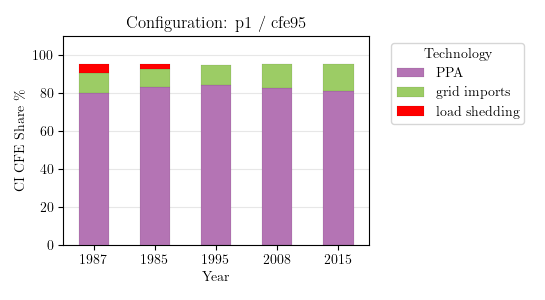

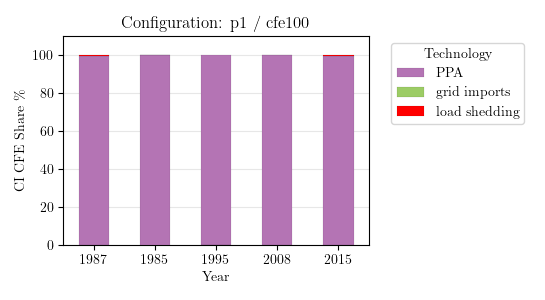

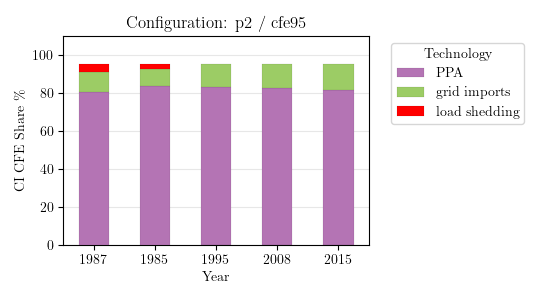

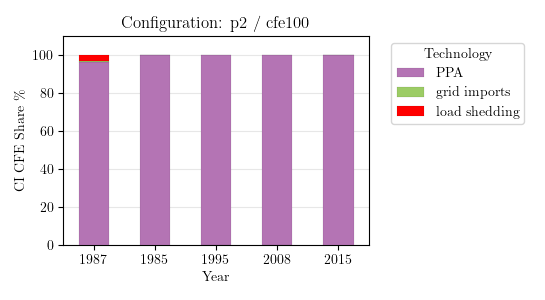

In [38]:
def plot_cfe_share_scen3(df, scenario, selected_years):
    # Filter DataFrame for selected years
    df = df[df['year'].isin(selected_years)]

    # Define types to plot and construct variable names
    types = ["local", "grid"]
    variable_names = [f"ci_fraction_clean_used_{t}" for t in types]

    # Filter for CFE share-related rows
    cfe_share_rows = df[df['variable'].isin(variable_names)].copy()

    # Rename using a dictionary comprehension and further mappings
    cfe_share_rows['variable'] = cfe_share_rows['variable'].map(
        {f"ci_fraction_clean_used_{t}": t for t in types}
    ).replace({"local": "PPA", "grid": "grid imports"})

    # Pivot the table for easier plotting
    plot_data = cfe_share_rows.pivot(index='year', columns='variable', values=scenario)

    # calculate shedding
    df = df.set_index(['variable', 'year'])
    for y in selected_years:
        load_shedding_value = df.loc[('ci_generation_load_shedding', y), scenario]
        total_demand_value = df.loc[('ci_demand_total', y), scenario]
        plot_data.loc[y, "load shedding"] = load_shedding_value / total_demand_value


    # Convert to percentages and round
    plot_data = (100 * plot_data).round(1)

    # Reorder the columns based on keys in the renaming dictionary if required
    ordered_cols = [col for col in preferred_order if col in plot_data.columns]
    extra_cols = [col for col in plot_data.columns if col not in ordered_cols]
    plot_data = plot_data[ordered_cols + extra_cols]
    # Reorder the rows according to the selected years
    plot_data = plot_data.loc[selected_years]

    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 3))
    plot_data.plot(kind="bar", stacked=True, ax=ax, color=tech_colors,edgecolor="black", linewidth=0.05,  zorder=10)
    ax.set_ylabel("CI CFE Share $\%$")
    ax.set_xlabel('Year')
    ax.set_ylim(0, 110)
    plt.xticks(rotation=0)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title(f'Configuration: {pal} / {scenario}')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_3_ci_cfe_share_{pal}_{scenario}.pgf', format='pgf')
    plt.show()

selected_years = [1987, 1985, 1995, 2008, 2015]
palette = ['p1', 'p2']
policy = ['cfe95', 'cfe100'] #'ref','res100', 
for pal in palette:
    df = pd.read_csv(f'../results/04_26-EU_DE_scenario_3_imports/csvs/10/2025/DE/{pal}/summary_weather_years.csv')
    for pol in policy:
        plot_cfe_share_scen3(df, pol, selected_years)

## scen3: power flow at CI bus

INFO:pypsa.io:Imported network cfe100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


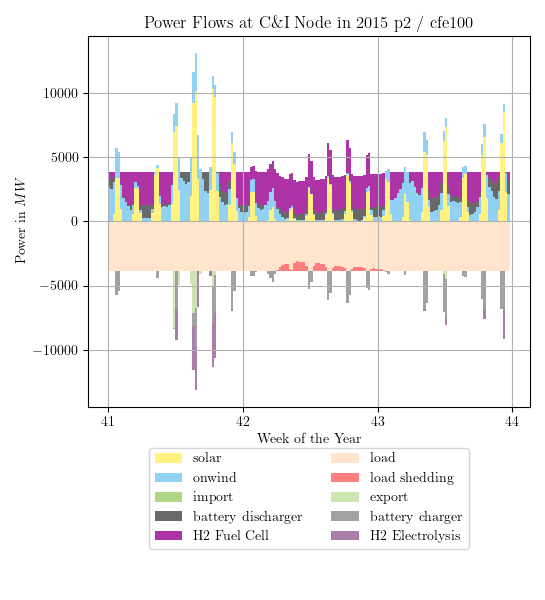

In [60]:
import matplotlib.dates as mdates

def plot_power(path, weeks_of_year):
    network = pypsa.Network(path)
    # Convert snapshots to datetime to filter by weeks
    network.snapshots = pd.to_datetime(network.snapshots)
    week_mask = network.snapshots.isocalendar().week.isin(weeks_of_year)
    time = network.snapshots[week_mask]

    color = {
        'solar' : '#ffef60',
        'onwind' : '#74c6f2',
        'load': '#ffcc99',
        'load shedding': 'red',
        'import': '#9ccc65',
        'export': '#9ccc65',
        'battery discharger': '#444444',
        'battery charger': '#444444',
        'H2 Electrolysis': '#550055',
        'H2 Fuel Cell': '#990090',
    }

    pos = ['solar', 'onwind', 'import', 'battery discharger', 'H2 Fuel Cell']
    neg = ['load', 'load shedding', 'export', 'battery charger', 'H2 Electrolysis']
    
    # Collect positive and negative data
    pos_data = {}
    neg_data = {}

    for item in pos:
        full_name = 'google ' + item
        if full_name in network.generators_t.p.columns:
            pos_data[item] = network.generators_t.p[full_name][week_mask]
        elif full_name in network.links_t.p1.columns:
            pos_data[item] = -network.links_t.p1[full_name][week_mask]
    
    for item in neg:
        full_name = 'google ' + item
        if full_name in network.loads_t.p_set.columns:
            neg_data[item] = -network.loads_t.p_set[full_name][week_mask]
        elif full_name in network.links_t.p0.columns:
            neg_data[item] = -network.links_t.p0[full_name][week_mask]
        elif full_name in network.generators_t.p.columns and item == 'load shedding':
            # Special case: load shedding is implemented as a generator but plotted as negative
            neg_data[item] = -network.generators_t.p[full_name][week_mask]
            #subtract load shedding from load
            neg_data['load'] -= neg_data[item]


    plt.figure(figsize=(5.45, 6))
        # Plotting positive contributions
    plt.stackplot(time, pos_data.values(), step='post', labels=[item for item in pos_data.keys()], colors=[color[item] for item in pos_data.keys()], alpha=0.8)
    # Plotting negative contributions
    plt.stackplot(time, neg_data.values(), step='post', labels=[item for item in neg_data.keys()], colors=[color[item] for item in neg_data.keys()], alpha=0.5)

    year = path.split('/')[-2]
    palette = path.split('/')[-3]
    policy = path.split('/')[-1].split('.')[0]
    plt.title(f'Power Flows at C\&I Node in {year} {palette} / {policy}')
    plt.ylabel('Power in $MW$')
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2)
    plt.grid(True)


    # Set the locator to weekly
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

    # Set the formatter to display the week number
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%V'))

    # Set x-label for the bottom plot
    plt.xlabel('Week of the Year')


    # Show plot
    plt.tight_layout()
    plt.savefig(f'../plots/scen3_power_flows_{palette}_{year}_{policy}.pgf', format='pgf')
    plt.show()

n = "../results/04_26-EU_DE_scenario_3_imports/networks/10/2025/DE/p2/2015/cfe100.nc" #"../results/04_22-EU_DE_scenario_3/networks/10/2025/DE/p2/1987/cfe100.nc"
plot_power(n, [i for i in range(41, 44)]) # specify interval of weeks of the year to plot

## scen3: fixed capacity

/tmp/ipykernel_53778/1325029640.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53778/1325029640.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53778/1325029640.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykerne

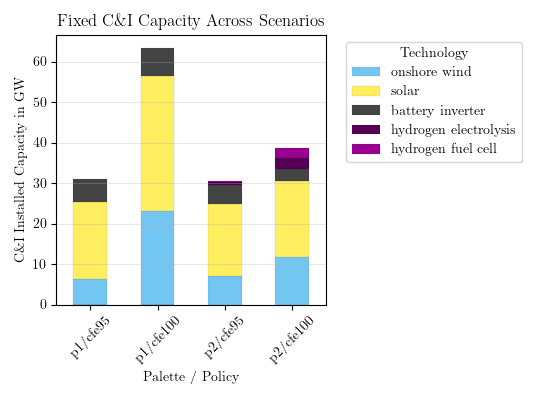

In [10]:
def plot_combined_capacity_1995(path, scenarios, palettes, year=1995):
    combined_data = pd.DataFrame()

    for pal in palettes:
        df = pd.read_csv(path.format(palette=pal))
        for scenario in scenarios:
            # Filter DataFrame for the selected year
            yearly_data = df[(df['year'] == year) & (df['variable'].str.startswith('ci_cap_'))]

            # Apply renaming to match the provided dictionary
            yearly_data['variable'] = yearly_data['variable'].str.replace('ci_cap_', '').replace(rename_ci_capacity)
            # Drop 'battery_charger' from capacity_rows
            yearly_data = yearly_data[~yearly_data['variable'].str.contains('battery_charger')]

            # Pivot the table for easier plotting
            plot_data = yearly_data.pivot(index='year', columns='variable', values=scenario)

            # Convert to GW and transpose for vertical plotting
            plot_data = (plot_data / 1000).transpose()

            # Rename columns to include scenario and palette information
            plot_data.columns = [f"{pal}/{scenario}"]

            # Combine data into one DataFrame
            combined_data = pd.concat([combined_data, plot_data], axis=1)
    combined_data = combined_data.T
    ordered_cols = [col for col in preferred_order if col in combined_data.columns]
    extra_cols = [col for col in combined_data.columns if col not in ordered_cols]
    combined_data = combined_data[ordered_cols + extra_cols]
    # Plotting
    fig, ax = plt.subplots()
    fig.set_size_inches((5.45, 4))
    combined_data.plot(kind="bar",stacked=True, ax=ax, color=tech_colors, edgecolor="black", linewidth=0.05)
    ax.set_ylabel("C\&I Installed Capacity in GW")
    ax.set_xlabel('Palette / Policy')
    plt.xticks(rotation=45)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_title('Fixed C\&I Capacity Across Scenarios')
    plt.tight_layout()
    plt.savefig(f'../plots/scen_3_fixed_capacity_.pgf', format='pgf')
    plt.show()

# Example use case
selected_year = 1995
palette = ['p1', 'p2']
policy = ['cfe95', 'cfe100']
path = '../results/04_26-EU_DE_scenario_3_imports/csvs/10/2025/DE/{palette}/summary_weather_years.csv'  # Assuming the structure is the same for all files
plot_combined_capacity_1995(path, policy, palette, selected_year)

## scen3: neg prices and power flow at ci node

INFO:pypsa.io:Imported network cfe95.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


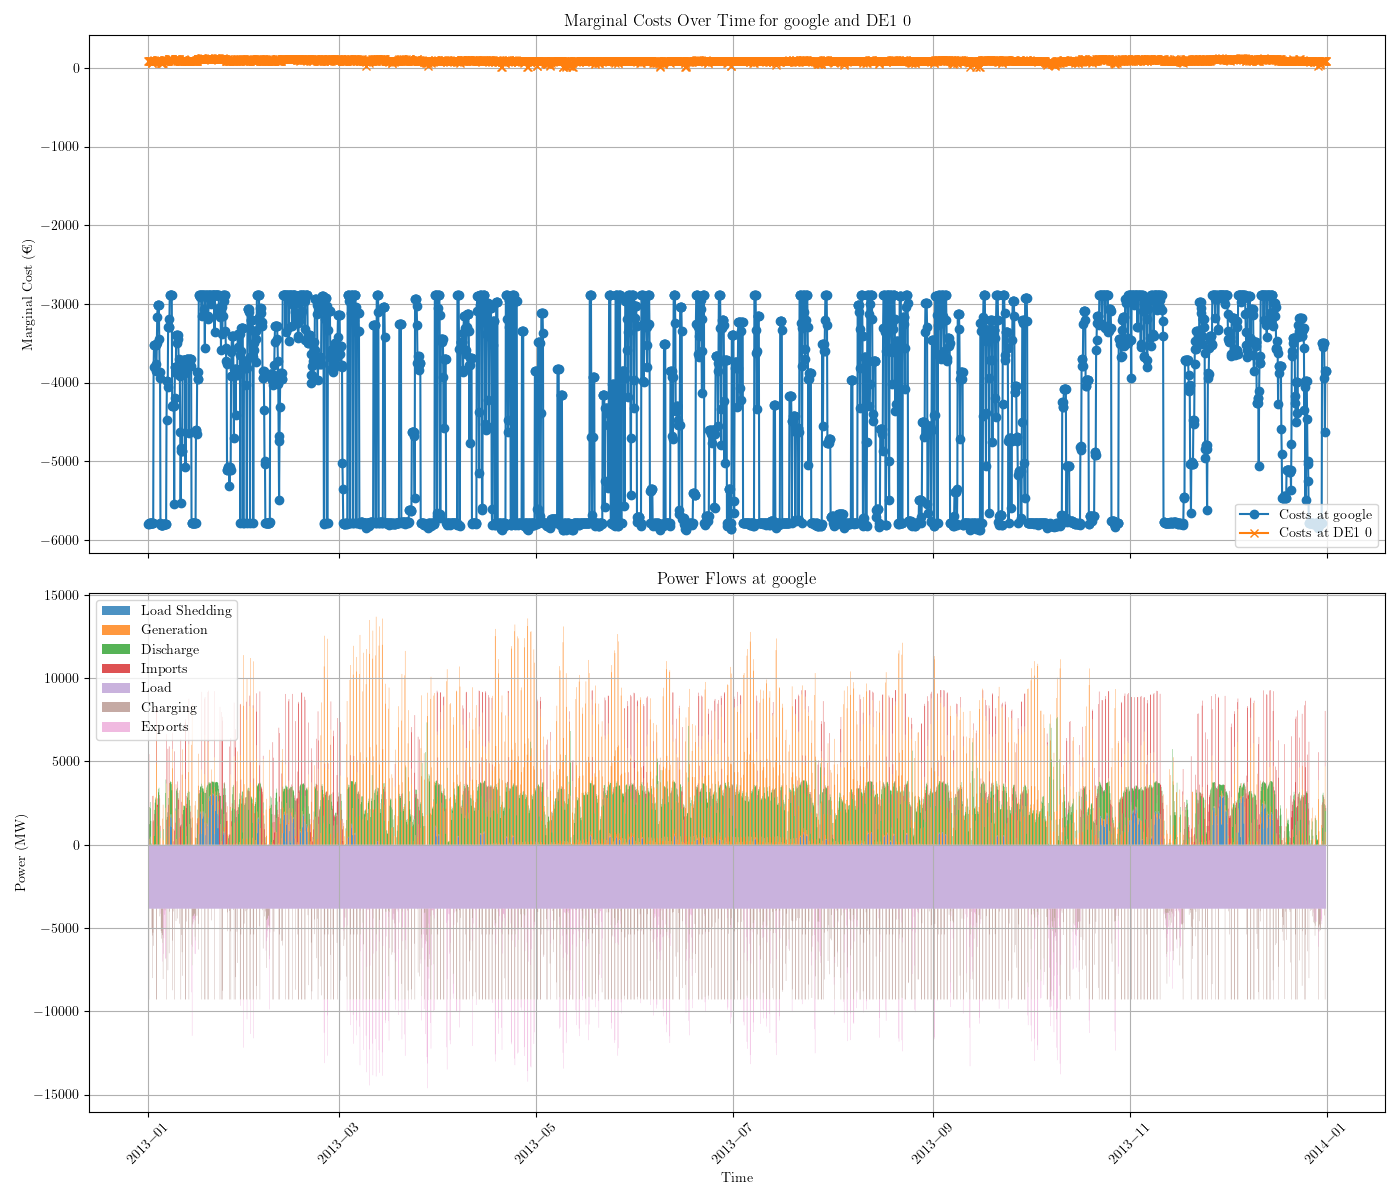

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_network_data(network, node1_name, node2_name):
    """
    Plots the dual variable (marginal prices) of two specified nodes as costs over time 
    and the power flows of the first node in a stacked area chart, both plots sharing the x-axis.
    
    Parameters:
    - network: A solved PyPSA Network object.
    - node1_name: A string, the name of the first node in the network whose costs and power flows are to be plotted.
    - node2_name: A string, the name of the second node in the network whose costs are to be plotted.
    """
    
    # Ensure the node names exist in the network's data
    if node1_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node1_name}' does not exist in the network's marginal prices.")
    if node2_name not in network.buses_t.marginal_price:
        raise ValueError(f"The specified node name '{node2_name}' does not exist in the network's marginal prices.")
    
    # Extract marginal prices
    marginal_prices_node1 = network.buses_t.marginal_price[node1_name]
    marginal_prices_node2 = network.buses_t.marginal_price[node2_name]
    
    # Prepare power flow data for the first node
    gen_name = ['google solar', 'google wind']
    
    discharge_link = 'google battery discharger'
    import_link = 'google import'
    charge_link = 'google battery charger'
    export_link = 'google export'
    
    # Extract and prepare power data, assuming naming conventions are correct and columns exist
    pos_data = {
        'Load Shedding' : network.generators_t.p.loc[:, f"{node1_name} load shedding"],
        'Generation': network.generators_t.p.loc[:, network.generators_t.p.columns.intersection(gen_name)].sum(axis=1),
        'Discharge': network.links_t.p0[discharge_link] if discharge_link in network.links_t.p0 else 0,
        'Imports': network.links_t.p0[import_link] if import_link in network.links_t.p0 else 0
    }
    neg_data = {
        'Load': -network.loads_t.p_set[f"{node1_name} load"] if f"{node1_name} load" in network.loads_t.p_set else 0,
        'Charging': -network.links_t.p0[charge_link] if charge_link in network.links_t.p0 else 0,
        'Exports': -network.links_t.p0[export_link] if export_link in network.links_t.p0 else 0
    }

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

    # Plotting marginal prices
    axs[0].plot(marginal_prices_node1.index, marginal_prices_node1.values, label=f'Costs at {node1_name}', marker='o')
    axs[0].plot(marginal_prices_node2.index, marginal_prices_node2.values, label=f'Costs at {node2_name}', marker='x')
    axs[0].set_title(f'Marginal Costs Over Time for {node1_name} and {node2_name}')
    axs[0].set_ylabel('Marginal Cost (€)')
    axs[0].legend()
    axs[0].grid(True)

    # Plotting power flows
    time = network.snapshots
    axs[1].stackplot(time, pos_data.values(), labels=pos_data.keys(), alpha=0.8, step='post')
    axs[1].stackplot(time, neg_data.values(), labels=neg_data.keys(), alpha=0.5, step='post')
    axs[1].set_title('Power Flows at ' + node1_name)
    axs[1].set_ylabel('Power (MW)')
    axs[1].legend(loc='upper left')
    axs[1].grid(True)

    # Set common x-axis properties
    plt.xlabel('Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage, assuming `network` is your loaded and solved PyPSA network object
n = pypsa.Network("../results/04_26-EU_DE_scenario_3_imports/networks/10/2025/DE/p1/1987/cfe95.nc")
plot_network_data(n, 'google', 'DE1 0')


# Network capacities generators links comparison

In [12]:
def plot_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each bus in given networks,
    and adds a subplot showing the difference in p_nom values between networks.
    Each dataframe is plotted in a subplot with consistent color coding for carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]

    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []

    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.generators['carrier'].unique())
    colors = mcolors.XKCD_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}
    carrier_colors.update({
        "offwind": "#6895dd",
        "offwind-ac": "#6895dd",
        "offwind-dc": "#6895dd",
        "onwind": "#74c6f2",
        "solar": "#ffef60",
        })

    for i, network in enumerate(networks):
        # Check if network has been solved and a valid p_nom_opt column exists
        if 'p_nom_opt' in network.generators.columns and not network.generators['p_nom_opt'].isna().any():
            capacity_column = 'p_nom_opt'
        else:
            capacity_column = 'p_nom'
            
        # Filtering only the relevant columns: 'bus', 'carrier', and 'p_nom'
        filtered_df = network.generators[['bus', 'carrier', capacity_column]]
        filtered_df.rename(columns={capacity_column: 'p_nom'}, inplace=True) if capacity_column != 'p_nom' else None

        # Group and sum the p_nom values per bus and carrier
        grouped_df = filtered_df.groupby(['bus', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_df)

        # Plotting on the respective subplot with consistent colors
        (grouped_df/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_df.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of {capacity_column} per Carrier for each Bus (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel(f'Sum of {capacity_column} [GW]')
        axes[i].grid(True, axis='y')
        
        #custom legend
        carrier_labels = [carrier for carrier in grouped_df.columns.get_level_values(1)]
        custom_legend = [plt.Line2D([0], [0], color=carrier_colors[carrier], lw=4) for carrier in carrier_labels]
        axes[i].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (Network 2 - Network 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')
        axes[-1].legend(custom_legend, carrier_labels, title="Carriers", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [9]:
def plot_link_capacity_summaries(*networks):
    """
    Plots the summaries of capacity (p_nom) per carrier for each link in given networks,
    filtering buses with carriers 'AC' or 'battery'.
    Each dataframe is plotted in a subplot with consistent color coding for link carriers.

    Parameters:
    *networks (variable number of pandas.DataFrame): networks to be plotted.
    """
    # Number of networks
    num_dfs = len(networks)

    # Creating subplots, with one extra for the difference plot
    fig, axes = plt.subplots(num_dfs + 1, 1, figsize=(10, 5 * (num_dfs + 1)))

    # Ensuring axes is a list even if there's only one subplot
    if num_dfs == 1:
        axes = [axes]
    
    # Initialize a DataFrame to store the summed values for difference calculation
    summed_values = []
    
    # Generate a consistent set of colors for carriers
    all_carriers = set()
    for network in networks:
        all_carriers.update(network.links['carrier'].unique())
    colors = mcolors.CSS4_COLORS
    carrier_colors = {carrier: color for carrier, color in zip(all_carriers, colors)}

    for i, network in enumerate(networks):
        # Filter for buses with 'AC' or 'battery' carriers
        ac_battery_buses = network.buses[network.buses.carrier.isin(['AC'])].index #'battery'

        # Filtering links with relevant buses and columns: 'bus1', 'carrier', and 'p_nom'
        filtered_links = network.links[network.links.bus1.isin(ac_battery_buses)]
        filtered_links = filtered_links[['bus1', 'carrier', 'p_nom']]

        # Group and sum the p_nom values per bus1 and carrier
        grouped_links = filtered_links.groupby(['bus1', 'carrier']).sum().unstack().fillna(0)
        summed_values.append(grouped_links)

        # Plotting on the respective subplot with consistent colors
        (grouped_links/1000).plot(kind='bar', stacked=True, ax=axes[i], color=[carrier_colors[carrier] for carrier in grouped_links.columns.get_level_values(1)])
        axes[i].set_title(f'Sum of p_nom per Carrier for each Link (Network {i+1})')
        axes[i].set_xlabel('Bus')
        axes[i].set_ylabel('Sum of p_nom [GW]')
        axes[i].grid(True, axis='y')
        axes[i].legend(title='Carrier')

            # Calculating and plotting the difference
    if num_dfs > 1:
        # Assuming only 2 networks for difference calculation
        difference_df = summed_values[1].subtract(summed_values[0], fill_value=0)
        (difference_df/1000).plot(kind='bar', stacked=True, ax=axes[-1], color=[carrier_colors[carrier] for carrier in difference_df.columns.get_level_values(1)])
        axes[-1].set_title('Difference in p_nom per Carrier for each Bus (DataFrame 2 - DataFrame 1)')
        axes[-1].set_xlabel('Bus')
        axes[-1].set_ylabel('Difference in Sum of p_nom [GW]')

        # Annotation for total difference
        total_difference_per_carrier = difference_df.sum(axis=0)
        annotation_text = "\n".join([f"{carrier}: {total_diff / 1000:.2f} GW" for carrier, total_diff in total_difference_per_carrier.iteritems()])
        axes[-1].text(0.5, 0.5, annotation_text, transform=axes[-1].transAxes, ha='center', fontsize=10)
        axes[-1].grid(True, axis='y')
        
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [10]:
# compare generator dataframe

def compare_generator_df(net1, net2):
    """
    Compare the generators dataframes of two PyPSA networks.
    
    :param net1: First PyPSA network object
    :param net2: Second PyPSA network object
    :return: DataFrame showing differences
    """
    # Extract generators dataframes
    gen1 = net1.generators
    gen2 = net2.generators

    # Align columns in both dataframes
    gen1, gen2 = gen1.align(gen2, axis=1)

    # Compare and find differences
    diff = pd.concat([gen1, gen2]).drop_duplicates(keep=False)

    return diff

## Comparison of input networks capacities (unsolved)

with comparing capacities I found a double attachment of vres capacities in pypsa-eur code.

In [7]:
n1 = pypsa.Network('../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc')
n2 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc')
n2 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_double_vre.nc')
plot_link_capacity_summaries(n1,n2)
plot_capacity_summaries(n1,n2)

INFO:pypsa.io:Imported network v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


KeyboardInterrupt: 

tryna find the capacity differences in solved networks.

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

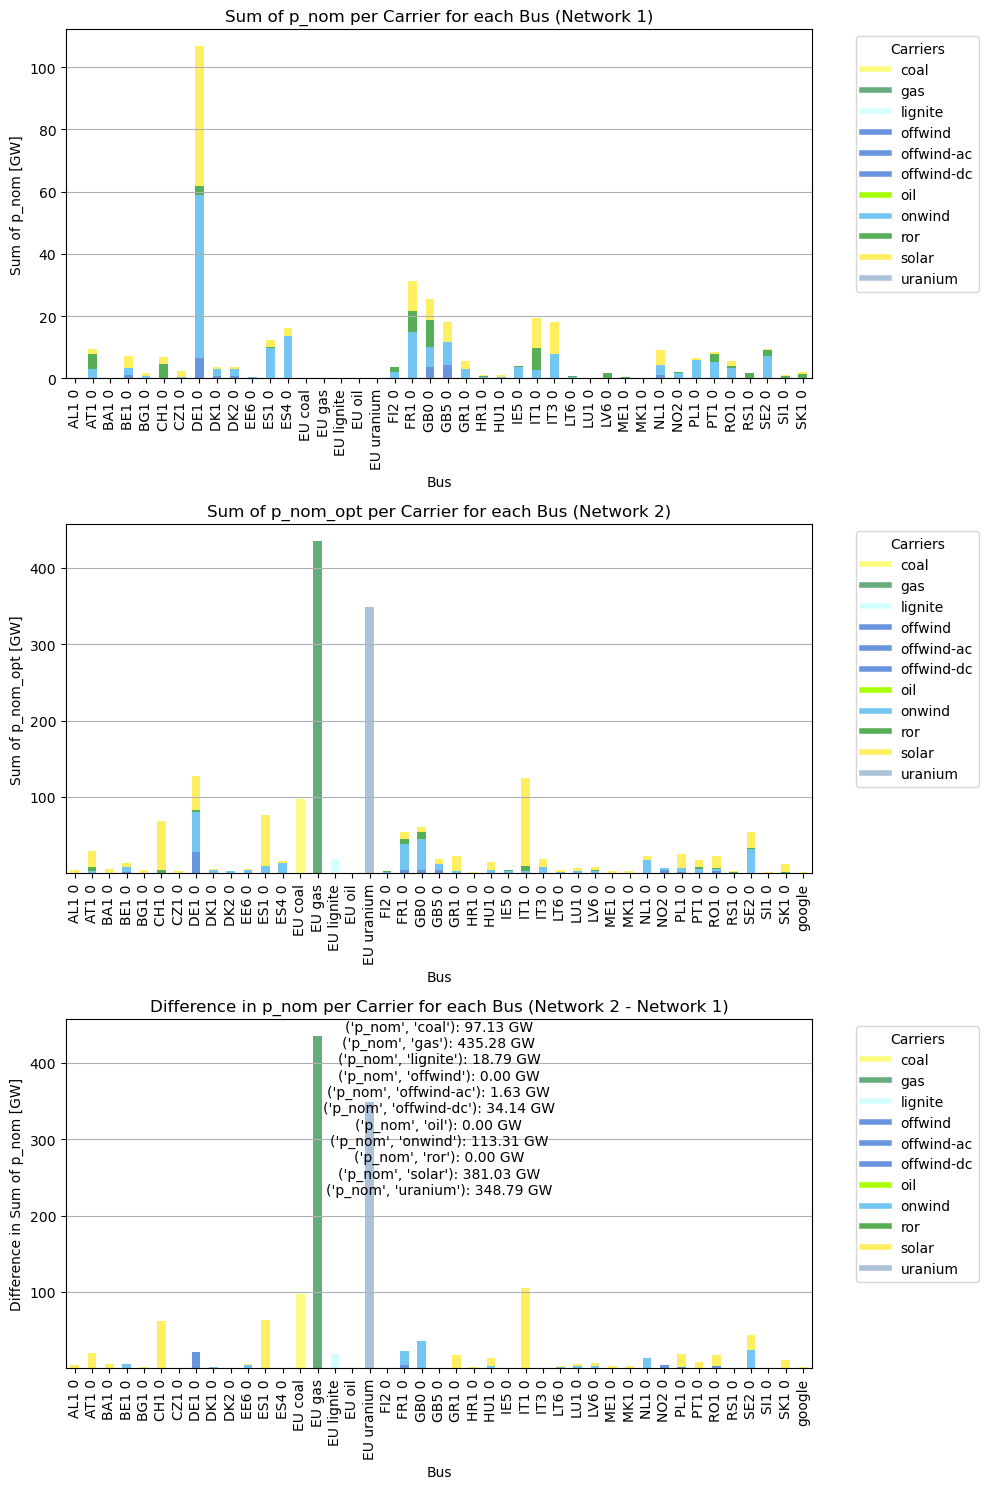

In [12]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025_fix_vre_SARAH.nc')# results/12_13_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')# 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_capacity_summaries(n1,n2)

Index(['AL1 0 residential rural biomass boiler-2025',
       'AT1 0 residential rural biomass boiler-2025',
       'BA1 0 residential rural biomass boiler-2025',
       'BE1 0 residential rural biomass boiler-2025',
       'BG1 0 residential rural biomass boiler-2025',
       'CH1 0 residential rural biomass boiler-2025',
       'CZ1 0 residential rural biomass boiler-2025',
       'DE1 0 residential rural biomass boiler-2025',
       'DK1 0 residential rural biomass boiler-2025',
       'DK2 0 residential rural biomass boiler-2025',
       ...
       'MK1 0 services urban decentral biomass boiler-2025',
       'NL1 0 services urban decentral biomass boiler-2025',
       'NO2 0 services urban decentral biomass boiler-2025',
       'PL1 0 services urban decentral biomass boiler-2025',
       'PT1 0 services urban decentral biomass boiler-2025',
       'RO1 0 services urban decentral biomass boiler-2025',
       'RS1 0 services urban decentral biomass boiler-2025',
       'SE2 0 services

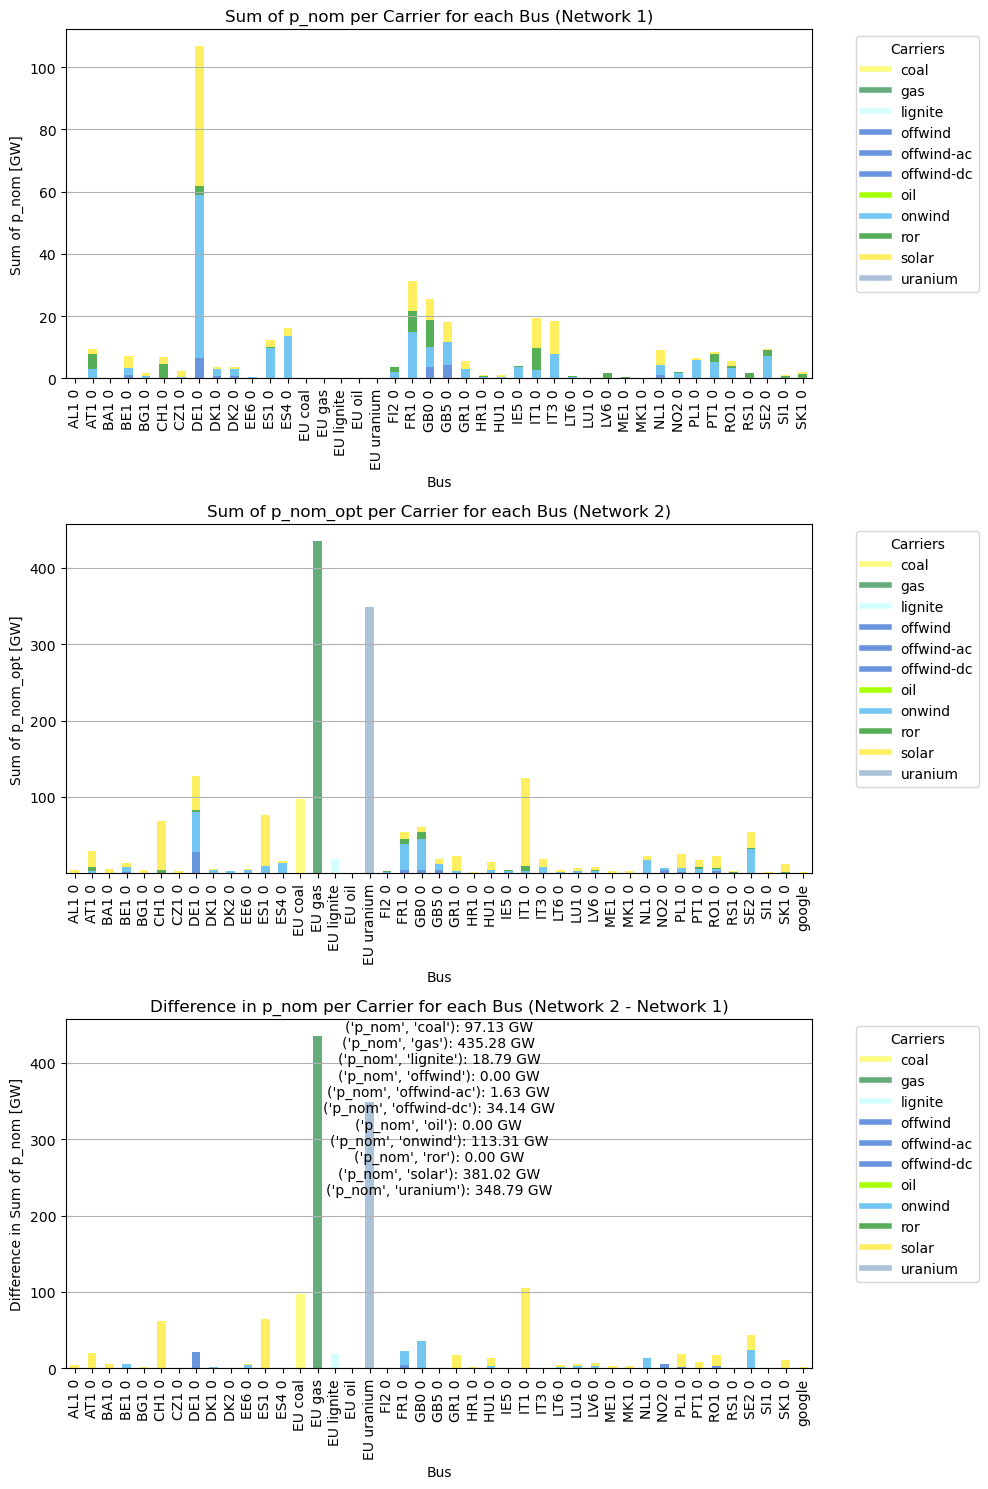

In [13]:
n1 = pypsa.Network('../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc')#'../../pypsa-eur/results/weatheryeartest/prenetworks/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../results/validationEU/networks/10/2025/IE/p1/2013/res100.nc') 
n2 = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc') #'../input/v6_elec_s_37_lv1.0__3H-B-solar+p3_2025.nc') #'../input/elec2013_s_37_lv1.0__3H-B-solar+p3_2025.nc') #
plot_capacity_summaries(n1,n2)

# Comparison of p_nom_max and p_nom_opt


In [31]:
def plot_bar_charts_adjacent(n):
    # Define the color scheme
    tech_colors = {
        "offwind": "#6895dd",  # offshore wind
        "onwind": "#74c6f2",   # onshore wind
        "ror": "#298c81",      # run of river
        "solar": "#ffef60"     # solar
    }

    # Adjust carrier names for offwind variants
    n.generators['carrier'] = n.generators['carrier'].replace(['offwind-dc', 'offwind-ac'], 'offwind')

    # Filter only relevant columns
    relevant_carriers = ['offwind', 'onwind', 'ror', 'solar']
    filtered_gens = n.generators[n.generators['carrier'].isin(relevant_carriers)]

    # Data for extendable and non-extendable generators
    extendable_gens = filtered_gens[filtered_gens.p_nom_extendable]
    extended_gens = extendable_gens[extendable_gens.p_nom_opt > 0]
    non_extendable_gens = filtered_gens[~filtered_gens.p_nom_extendable]

    # Group and sum data
    sum_extendable = extendable_gens.groupby(['bus', 'carrier']).p_nom_max.sum().unstack(fill_value=0).div(1000)
    sum_extended = extended_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)
    sum_non_extendable = non_extendable_gens.groupby(['bus', 'carrier']).p_nom_opt.sum().unstack(fill_value=0).div(1000)

    # Ensure both dataframes have the same index and columns
    common_index = sum_extendable.index.union(sum_non_extendable.index)
    common_columns = relevant_carriers
    sum_extendable = sum_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_extended = sum_extended.reindex(index=common_index, columns=common_columns, fill_value=0)
    sum_non_extendable = sum_non_extendable.reindex(index=common_index, columns=common_columns, fill_value=0)

    # Plotting
    fig, ax = plt.subplots(3,1,figsize=(15, 15))

    # Width of a bar
    bar_width = 0.2

    # Positions of the extendable and non-extendable bars
    index = np.arange(len(common_index))
    extendable_pos = index + bar_width
    extended_pos = index
    non_extendable_pos = index - bar_width

    """# Stacked bar chart for extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_extendable.columns:
        ax[0].bar(extendable_pos, sum_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extendable[col].values"""
        
    #stacked bar chart for extended generators
    bottom = np.zeros(len(common_index))
    for col in sum_extended.columns:
        ax[0].bar(extended_pos, sum_extended[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_extended[col].values

    # Stacked bar chart for non-extendable generators
    bottom = np.zeros(len(common_index))
    for col in sum_non_extendable.columns:
        ax[0].bar(non_extendable_pos, sum_non_extendable[col], bar_width, bottom=bottom, color=tech_colors.get(col, '#333333'), label='Non-Ext: ' + col if np.all(bottom == 0) else "")
        bottom += sum_non_extendable[col].values

    ax[0].set_xlabel('Bus')
    ax[0].set_ylabel('Generator Capacity [GW]')
    ax[0].set_title('Extendable and Non-Extendable Generator Capacities by Bus and Carrier')
    ax[0].set_xticks(index)
    ax[0].set_xticklabels(common_index, rotation=90)
    ax[0].legend()
    
    # Plot 2: Bar Chart for Quotients
    quotient = sum_non_extendable.div(sum_extendable.where(sum_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[1], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[1].set_title('Quotient of already build capacity (<2020) and maximum potential per Carrier')
    ax[1].set_ylabel('Quotient')
    
    # Plot 3: Bar Chart for Quotients
    quotient = sum_extended.div(sum_non_extendable.where(sum_non_extendable != 0, 0.000001))  # Avoid division by zero
    quotient.pop('ror')  # Remove run of river generators
    quotient.plot(kind='bar', ax=ax[2], color=[tech_colors.get(x, '#333333') for x in quotient.columns])
    ax[2].set_title('Quotient of extended capacity (>2020) and already build capacity (<2020) per Carrier')
    ax[2].set_ylabel('Quotient')


    plt.tight_layout()
    plt.show()

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


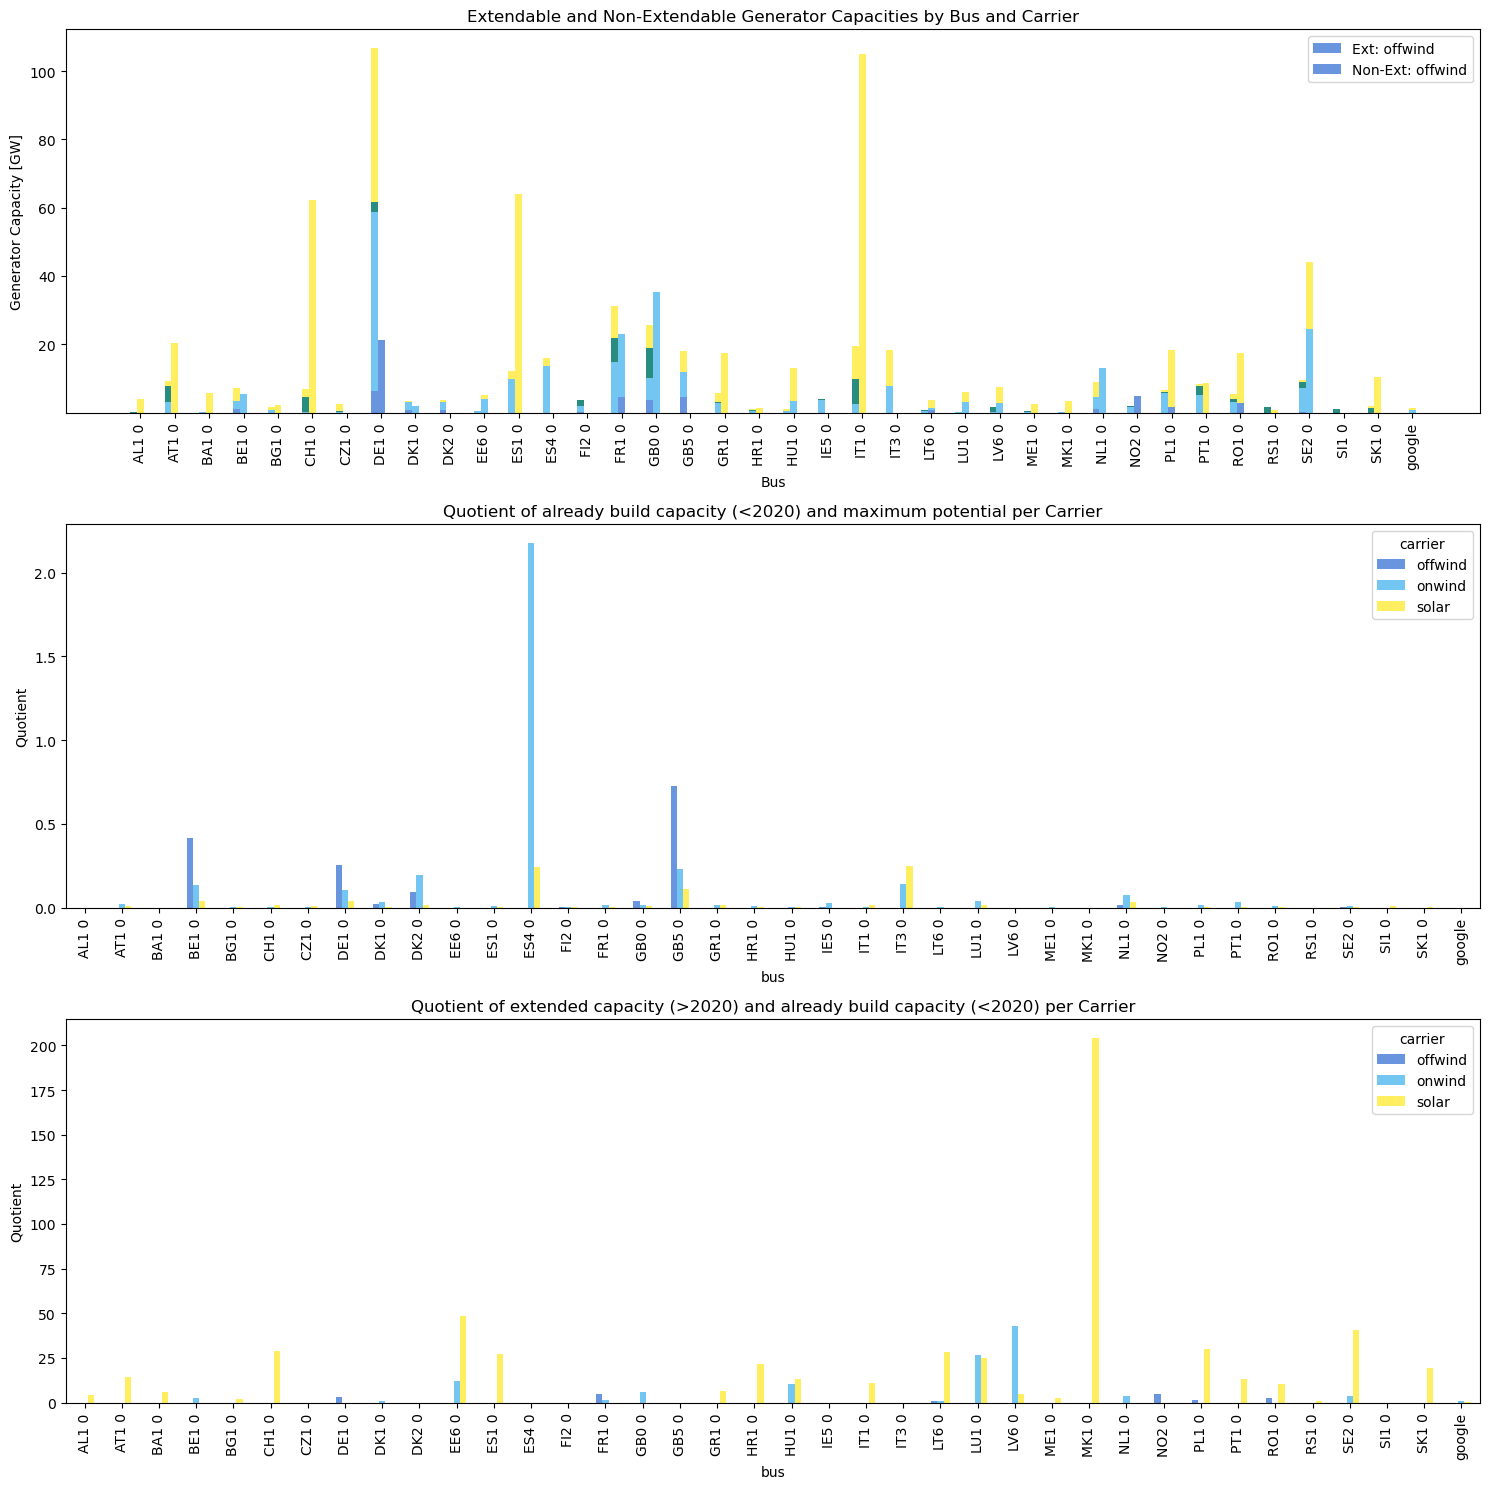

In [27]:
n = pypsa.Network('../results/12_07_validationEU_fix_vre_SARAH/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)

INFO:pypsa.io:Imported network res100.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:2042: RuntimeWarning:

invalid value encountered in scalar add

/home/tillotillson/mambaforge/envs/247-env/lib/python3.11/site-packages/matplotlib/transforms.py:383: RuntimeWarning:

invalid value encountered in scalar subtract



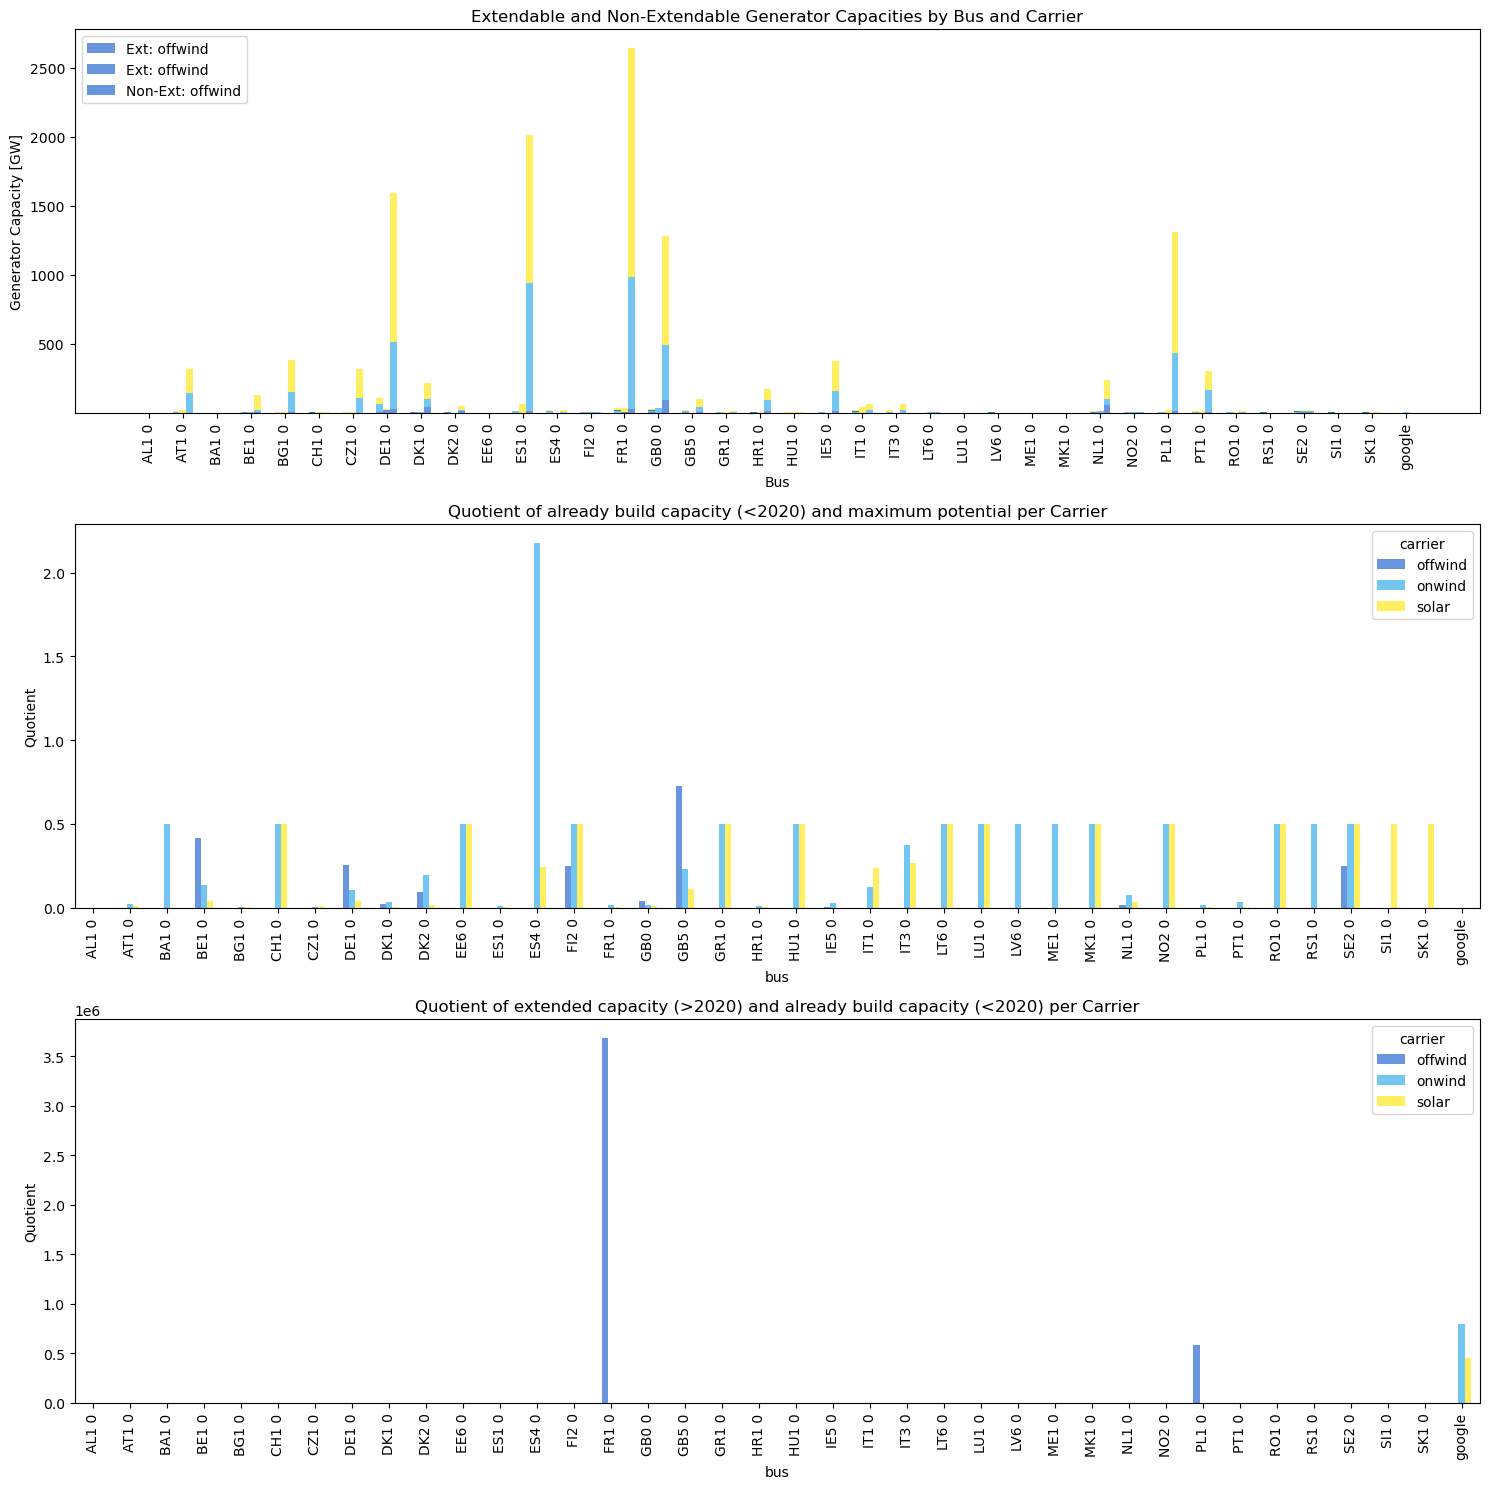

In [32]:
n = pypsa.Network('../results/01_02_validationEU_limitres/networks/10/2025/IE/p1/2013/res100.nc')
plot_bar_charts_adjacent(n)

/tmp/ipykernel_10781/448274757.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



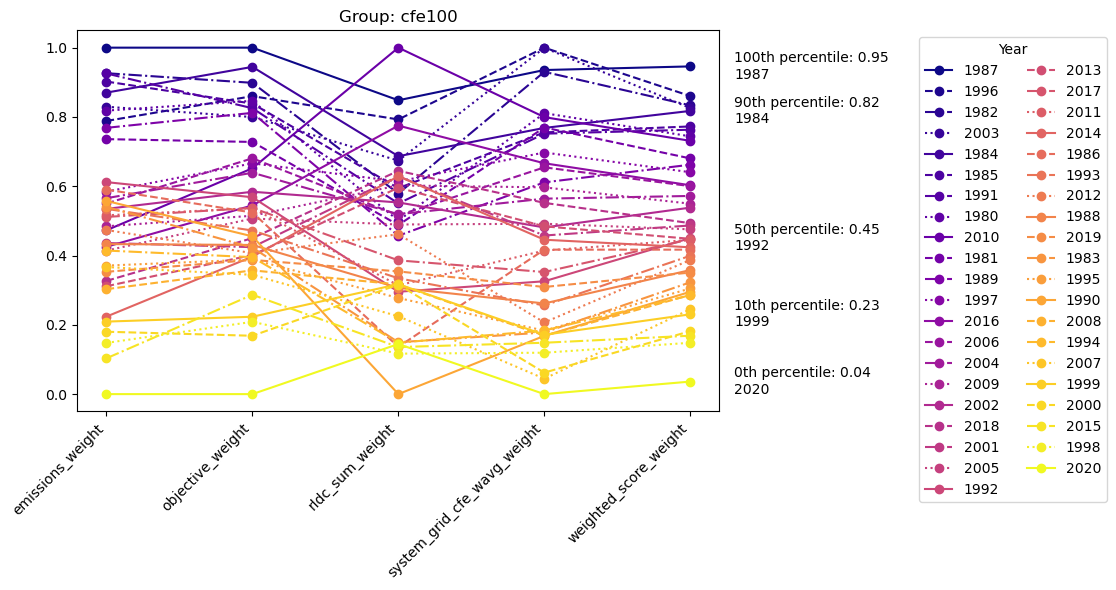

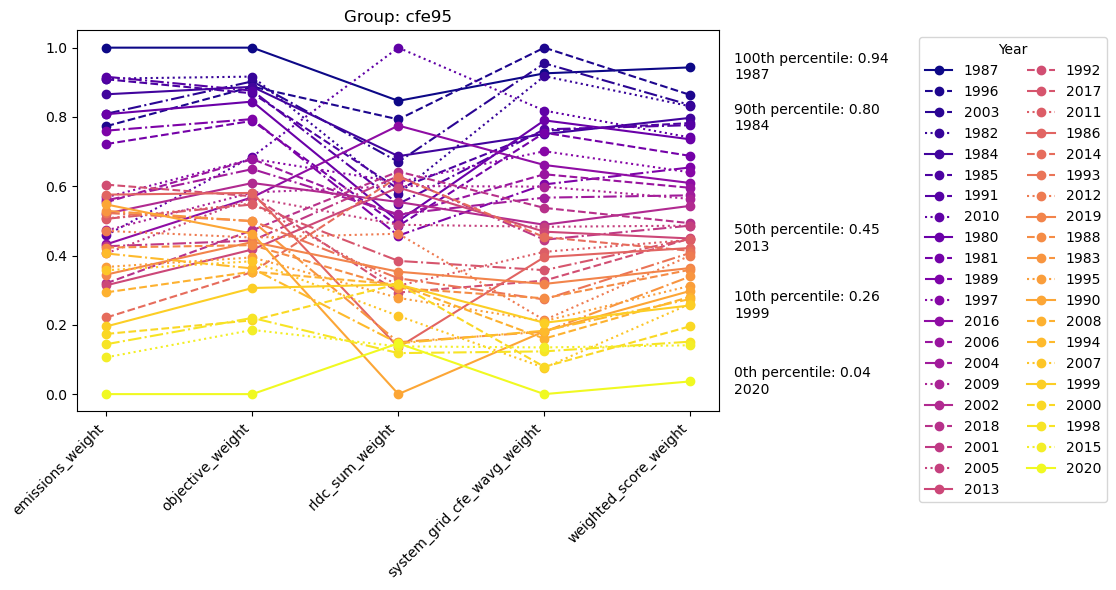

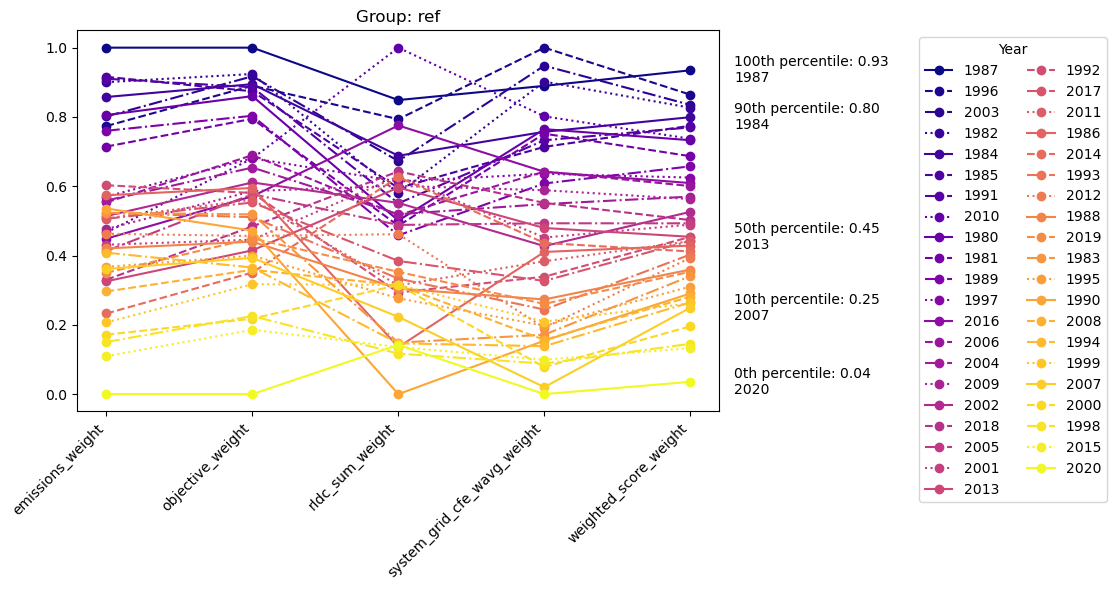

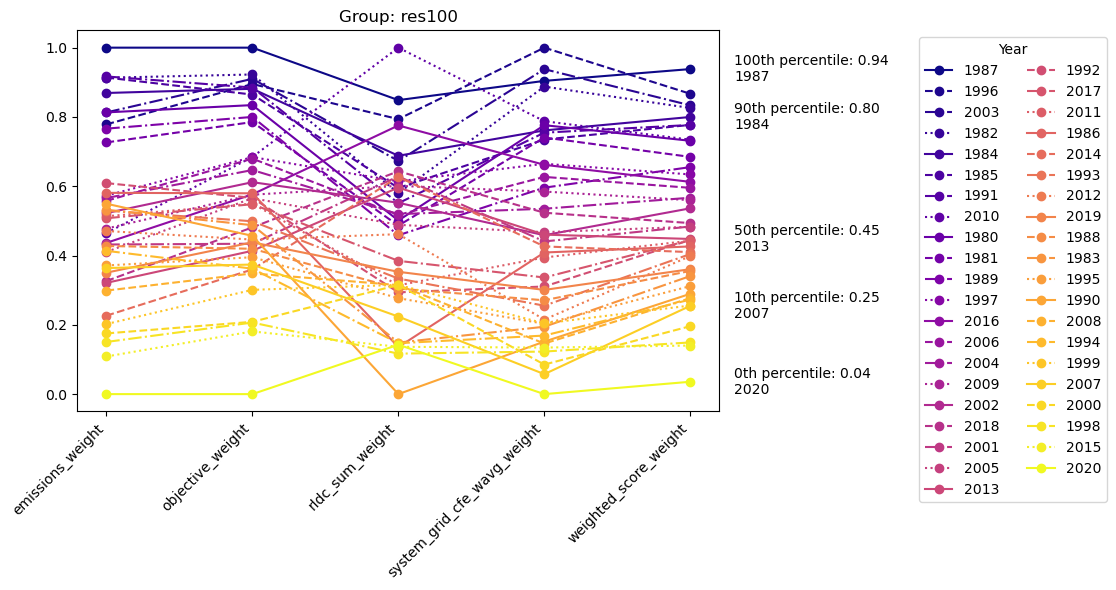

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Read in the dataframe
df = pd.read_csv('../results/02_27-EU/csvs/10/2025/DE/p1/summary_pick.csv')

# Split the dataframe based on the unique values in the first column
groups = df.groupby(df.columns[0])

# Prepare the colormap
total_years = len(df['year'].unique())
colormap = cm.get_cmap('plasma', total_years)  # Get the 'plasma' colormap
normalize = mcolors.Normalize(vmin=0, vmax=total_years-1)

line_styles = ['-', '--', '-.', ':']
markers = ['o'] #, 's', '^', 'D', '*', 'p', 'h']

# Iterate over each group
for group_name, group_df in groups:
    fig, ax = plt.subplots(figsize=(12, 6))

    # Identify columns to plot, excluding the last "result" column
    columns_to_plot = [column for column in group_df.columns if '_weight' in column or '_score' in column]

    # Plot the line plots for each year
    for i, (index, row) in enumerate(group_df.iterrows()):
        # Extract the year and the values for the criteria columns
        year = row['year']
        # Calculate the color
        color = colormap(normalize(i))
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]
        # Plot the criteria performances for this year
        ax.plot(columns_to_plot, row[columns_to_plot], linestyle=linestyle, marker=marker, label=str(year), color=color)

    # Calculate specific percentiles
    percentiles = [100, 90, 50, 10, 0]
    percentile_values = np.percentile(group_df['weighted_score_weight'], percentiles)
    # Highlight and annotate the percentiles
    for percentile, value in zip(percentiles, percentile_values):
        closest_year = group_df.iloc[(group_df['weighted_score_weight']-value).abs().argsort()[:1]]['year'].values[0]
        #ax.axhline(y=value, linestyle='--', color='gray', alpha=0.7)
        ax.text(len(columns_to_plot)-0.7 , value, f'{percentile}th percentile: {value:.2f}\n{closest_year}', verticalalignment='center')
        
    # Add legend and labels
    ax.legend(loc='upper left', bbox_to_anchor=(1.3 ,1), title='Year', ncol=2)
    ax.set_title(f'Group: {group_name}')

    # Improve the layout
    plt.xticks(rotation=45, ha="right")  # Rotate the x-axis labels for better readability
    plt.tight_layout()  # Adjust the layout to make room for the legend and x-axis labels

    # Show the plot
    plt.show()

